In [1]:
#experiment name and snapshot folder (used for model persistence)
experiment_setup_name = "tutorial.gym.atari.CrazyClimber-v0.cnn"
snapshot_path = "."


#gym game title
GAME_TITLE = 'KungFuMaster-v0'

#how many parallel game instances can your machine tolerate
N_PARALLEL_GAMES = 10


#how long is one replay session from a batch

#since we have window-like memory (no recurrent layers), we can use relatively small session weights
replay_seq_len = 25

In [2]:
#this is my machine-specific config. replace if are not me.

#theano device selection
%env THEANO_FLAGS='device=gpu2'


#snapshot path - where neural network snapshots are saved during the main training loop
!mkdir ./agentnet_snapshots/
snapshot_path = "./agentnet_snapshots/"


env: THEANO_FLAGS='device=gpu2'
mkdir: cannot create directory `./agentnet_snapshots/': File exists


# This tutorial is a showcase on how to use advanced AgentNet techniques 


# [new]

* The notebook is mostly based on "Playing atari with Deep Reinforcement Learning (OpenAI Gym)" example
 * All changes against that example will be marked with #[new] sign, like one above
* We use a recurrent memory layer, implemented via Gated Recurrent Unit
* We use advantage actor-critic method to train agent (using policy + state values instead of q-values)
* We train agent to hurt humans in KungFu master game
* We also use a bit heavier a network to process inputs (~convolutional from basic example)
  * If you have no GPU and want agent to train faster than human child, replace it with what worked in basic example

## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym
  
  
### Installing it
 * If nothing changed on their side, to run this, you bacically need to follow their install instructions - 
 
```
git clone https://github.com/openai/gym.git
cd gym
pip install -e .[all]
```

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports

import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


Using gpu device 2: Tesla K40m (CNMeM is disabled, CuDNN 4004)


In [4]:
%load_ext autoreload
%autoreload 2

# Experiment setup
* Here we basically just load the game

[2016-05-01 23:57:11,682] Making new env: KungFuMaster-v0


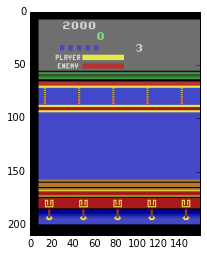

In [5]:
import gym
atari = gym.make(GAME_TITLE)
atari.reset()
plt.imshow(atari.render('rgb_array'))

### Game Parameters
* observation dimensions, actions, etc

In [6]:
n_actions = atari.action_space.n
observation_shape = (None,)+atari.observation_space.shape
action_names = atari.get_action_meanings()
print action_names

['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


In [7]:
del atari

# agent setup step by step
* An agent implementation may contain these parts:
 * Observation(s)
   * InputLayers where observed game states (here - images) are sent at each tick 
 * Memory layer(s)
   * A dictionary that maps "New memory layers" to "prev memory layers"
 * Policy layer (e.g. Q-values or probabilities)
   * in this case, a lasagne dense layer based on observation layer
 * Resolver - acton picker layer
   * chooses what action to take given Q-values
   * in this case, the resolver has epsilon-greedy policy
  




##### Agent observations

* Here you define where observations (game images) appear in the network
* You can use any lasagne architecture you want. We provide several examples

In [8]:
import lasagne

from lasagne.layers import InputLayer,DropoutLayer,DenseLayer, ExpressionLayer, Conv2DLayer,MaxPool2DLayer
from lasagne.layers import flatten, dimshuffle

In [9]:


#image observation
observation_layer = lasagne.layers.InputLayer(observation_shape,
                                                    name="images input")

observation_reshape = lasagne.layers.dimshuffle(observation_layer,(0,3,1,2))



# [ part where heavy convolutional network is defined]
#if you have to GPU, consider something lighter

#conv
cnn = Conv2DLayer(observation_reshape, num_filters=32,filter_size=(5,5),name='conv0')
cnn = Conv2DLayer(cnn, num_filters=32,filter_size=(5,5),name='conv1')
cnn = MaxPool2DLayer(cnn,(5,5))

#dense with dropout    
dnn = DenseLayer(cnn,num_units=500,name='dense0')
dnn = DropoutLayer(dnn,name = "dropout", p=0.05) #will get deterministic during evaluation
dnn = DenseLayer(dnn,num_units=300,name='dense1')

# [end of that part]

inp_nn = dnn

  
### Agent memory states
 * Here you can define arbitrary transitions between "previous state" variables and their next states
 * The rules are
   * previous states must be input layers
   * next states must have same shape as previous ones
   * otherwise it can be any lasagne network
   * AgentNet.memory has several useful layers
   
 * During training and evaluation, your states will be updated recurrently
   * next state at t=1 is given as previous state to t=2
 
 * Finally, you have to define a dictionary mapping new state -> previous state


Atari game environments are known to have __flickering__ effect where some sprites are shown only on odd frames and others on even ones - that was used to optimize performance at the time.

To compensate for this, we shall use the memory layer called __WindowAugmentation__ which basically maintains a K previous time steps of what it is fed with.


# [new]
We shall also use a GRUMemoryLayer to represent agent's recurrent memory state. This state is updated on every turn given window state.
Not that this is __not the same__ as `lasagne.layers.GRULayer` as GRUMemoryLayer only does a single time tick (lasagne version iterates over the whole sequence).



In [10]:

#memory
#using simple window-based memory that stores several states
#the SpaceInvaders environment does not need any more as it is almost fully-observed
from agentnet.memory import WindowAugmentation, GRUMemoryLayer


#our window
window_size = 3
prev_window = InputLayer((None,window_size,inp_nn.output_shape[1]),
                                        name = "previous window state")

window = WindowAugmentation(inp_nn,prev_window,name = "new window state")



# first (and so far only) GRU layer

gru0_size = 256

prev_gru0 = InputLayer((None,gru0_size),name="previous GRU0 state")

#neuron-wise maxima of window frames as an input to the GRU
window_max = ExpressionLayer(window,function=lambda v: v.max(axis=1), 
                             output_shape=inp_nn.output_shape,
                             name = 'window_max')


window_max = lasagne.layers.FeaturePoolLayer(window,window_size)

gru0 = GRUMemoryLayer(gru0_size,
                      observation_input = window_max,
                      prev_state_input = prev_gru0,
                      name="gru0"
                  )



#a dictionary that maps next agent memory states to previous ones
from collections import OrderedDict
memory_dict = OrderedDict([(window,prev_window),
                           (gru0,prev_gru0)])



##### Agent policy and action picking


# [new]

* Since we are using Actor-Critic method, we need to predict 2 values:
  * State value - basicly a Q-value of best action in a state
  * Agent policy - probabilities of taking actions
  

* To pick actions, we use a probablistic resolver
  * That one picks actions with given probabilities
  * We use a laplacian smoothing to pick actions in training (to bolster exploration) 
  * The resolver output is considered agent's next action and sent into the environment

In [11]:
#State values
state_value_layer = DenseLayer(gru0,
                               num_units = 1,
                               nonlinearity = lasagne.nonlinearities.linear,
                               name = "Vpredicted")


#a2c probabilities


policy_layer_pre_softmax = DenseLayer(gru0,
                                     num_units = n_actions,
                                     nonlinearity= None,
                                     name="policy_original")


from lasagne.layers import NonlinearityLayer
policy_layer = NonlinearityLayer(policy_layer_pre_softmax,
                                 lasagne.nonlinearities.softmax)


#actual action probablilities
epsilon = theano.shared(np.float32(0.1),"epsilon")


#add laplacian smoothing
smooth_policy_layer = NonlinearityLayer(
    policy_layer_pre_softmax,
    lambda v: lasagne.nonlinearities.softmax(v*(1.-epsilon) + epsilon/n_actions)
)





#resolver

from agentnet.resolver import ProbablisticResolver


resolver = ProbablisticResolver(smooth_policy_layer,assume_normalized=True,name="resolver")



##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

# [new]
* Note that we can have any (incl. none) number of agent policy variables,
* so you can use that to track any layer output
* It is also possible to have multiple observations and actions, but that's not aplicable to Atari environment

In [12]:
from agentnet.agent import Agent


#all together
agent = Agent(observation_layer,
              memory_dict,
              [policy_layer,state_value_layer],
              resolver)


In [13]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params((resolver,state_value_layer),trainable=True)
weights

[conv0.W,
 conv0.b,
 conv1.W,
 conv1.b,
 dense0.W,
 dense0.b,
 dense1.W,
 dense1.b,
 gru0.W_in_to_updategate,
 gru0.W_hid_to_updategate,
 gru0.b_updategate,
 gru0.W_in_to_resetgate,
 gru0.W_hid_to_resetgate,
 gru0.b_resetgate,
 gru0.W_in_to_hidden_update,
 gru0.W_hid_to_hidden_update,
 gru0.b_hidden_update,
 policy_original.W,
 policy_original.b,
 Vpredicted.W,
 Vpredicted.b]

# Agent step function
* Compute action and next state given observation and prev state
* The code was written in a generic way and did not undergo any changes since previous turorial

In [14]:
applier_observation = T.tensor4("input image",dtype=floatX)


# inputs to all agent memory states (usng lasagne defaults, may use any theano inputs)
applier_memories = OrderedDict([ (new_st,prev_st.input_var)
                                for new_st, prev_st in agent.state_variables.items()
                               ])


res =agent.get_agent_reaction(applier_memories,
                              applier_observation,
                              deterministic = True #disable dropout here. Only enable in experience replay
                             )


applier_actions,applier_new_states,applier_policy = res

applier_fun = theano.function([applier_observation]+applier_memories.values(),
        applier_actions+applier_new_states)


In [15]:
#a nice pythonic interface
def step(observation, prev_memories = 'zeros',batch_size = N_PARALLEL_GAMES):
    """ returns actions and new states given observation and prev state
    Prev state in default setup should be [prev window,]"""
    #default to zeros
    if prev_memories == 'zeros':
        prev_memories = [np.zeros((batch_size,)+tuple(mem.output_shape[1:]),
                                  dtype=floatX) 
                         for mem in agent.state_variables]
    
    res = applier_fun(np.array(observation),*prev_memories)
    action = res[0]
    memories = res[1:]
    return action,memories

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* We define a small container that stores
 * game emulators
 * last agent observations
 * agent memories at last time tick
* This allows us to instantly continue a session from where it stopped



* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf

In [16]:
#A whole lot of space invaders

class GamePool:
    def __init__(self,game_title,n_games):
        """
        A pool that stores several
           - game states (gym environment)
           - prev_observations - last agent observations
           - prev memory states - last agent hidden states
           
       """
        
        
        self.ataries = [gym.make(game_title) for i in range(n_games)]

        self.prev_observations = [atari.reset() for atari in self.ataries]
    
        self.prev_memory_states = 'zeros'

pool = GamePool(GAME_TITLE, N_PARALLEL_GAMES)


[2016-05-01 23:57:14,077] Making new env: KungFuMaster-v0
[2016-05-01 23:57:14,116] Making new env: KungFuMaster-v0
[2016-05-01 23:57:14,155] Making new env: KungFuMaster-v0
[2016-05-01 23:57:14,193] Making new env: KungFuMaster-v0
[2016-05-01 23:57:14,232] Making new env: KungFuMaster-v0
[2016-05-01 23:57:14,271] Making new env: KungFuMaster-v0
[2016-05-01 23:57:14,309] Making new env: KungFuMaster-v0
[2016-05-01 23:57:14,348] Making new env: KungFuMaster-v0
[2016-05-01 23:57:14,386] Making new env: KungFuMaster-v0
[2016-05-01 23:57:14,424] Making new env: KungFuMaster-v0


In [17]:
# a function that creates and records environment interaction sessions
def interact(pool,n_steps = 100,verbose=False):
    """generate interaction sessions with ataries (openAI gym atari environments)
    Sessions will have length n_steps. 
    Each time one of games is finished, it is immediately getting reset"""
    history_log = []
        
    prev_observations = pool.prev_observations 
    
    prev_memory_states = pool.prev_memory_states
    
    
    
    for i in range(n_steps):
        
        actions,new_memory_states = step(prev_observations,prev_memory_states)

        
        new_observations, cur_rewards, is_done, infos = \
            zip(*map(
                     lambda atari, action: atari.step(action), 
                     pool.ataries,actions))
            
        new_observations = np.array(new_observations)
        
        for i in range(len(pool.ataries)):
            if is_done[i]:
                new_observations[i] = pool.ataries[i].reset()
                
                for m_i in range(len(new_memory_states)):
                    new_memory_states[m_i][i] = 0
                    
                if verbose:
                    print "atari",i,"reloaded"
        
        
        #append observation -> action -> reward tuple
        history_log.append((prev_observations,actions,cur_rewards,new_memory_states,is_done,infos))
        
        prev_observations = new_observations
        prev_memory_states = new_memory_states
                
    pool.prev_memory_states = prev_memory_states
    pool.prev_observations = prev_observations
    
    return zip(*history_log)
    

In [18]:
%%time
observation_log,action_log,reward_log,_,_,_  = interact(pool,50)


print np.array(reward_log)[:10].T
print np.array(action_names)[np.array(action_log)[:3,:5]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[['DOWNFIRE' 'NOOP' 'NOOP' 'UPRIGHTFIRE' 'UP']
 ['NOOP' 'RIGHTFIRE' 'RIGHT' 'LEFT' 'NOOP']
 ['LEFT' 'NOOP' 'UPRIGHTFIRE' 'UPLEFTFIRE' 'DOWNRIGHTFIRE']]
CPU times: user 1.79 s, sys: 284 ms, total: 2.08 s
Wall time: 2.15 s


# experience replay pool

Since our network exists in a theano graph and OpenAI gym doesn't, we shall train out network via experience replay.

To do that in AgentNet, one can use a SessionPoolEnvironment.

It's simple: you record new sessions using `interact(...)`, and than immediately train on them.

1. Interact with Atari, get play sessions
2. Store them into session environment
3. Train on them
4. Repeat


In [19]:
#Create an environment with all default parameters
from agentnet.environment import SessionPoolEnvironment
env = SessionPoolEnvironment(observations = observation_layer,
                             actions=resolver,
                             agent_memories=[])

In [20]:
def update_pool(env, pool,n_steps=100):
    """ a function that creates new sessions and ads them into the pool
    throwing the old ones away entirely for simplicity"""

    
    observation_log,action_log,reward_log,_,is_done_log,_= interact(pool,n_steps=n_steps)
    
    
    #tensor dimensions
    
    # [batch_i, time_i, width, height, rgb]
    observation_tensor = np.array(observation_log).swapaxes(0,1)
    
    # [batch_i,time_i]
    action_tensor = np.array(action_log).swapaxes(0,1)
    
    # [batch_i, time_i]
    reward_tensor = np.array(reward_log).swapaxes(0,1)

    # [batch_i, time_i]
    is_alive_tensor = 1- np.array(is_done_log,dtype = 'int8').swapaxes(0,1)
    
    env.load_sessions(observation_tensor,action_tensor,reward_tensor,is_alive_tensor,[])
    
    

In [21]:
#load first  sessions
update_pool(env,pool,replay_seq_len)

A more sophisticated way of training is to store a large pool of sessions and train on random batches of them. 
* Why that is expected to be better - http://www.nature.com/nature/journal/v518/n7540/full/nature14236.html
* Or less proprietary - https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

To do that, one might make use of
* ```env.load_sessions(...)``` - load new sessions
* ```env.get_session_updates(...)``` - does the same thing via theano updates (advanced)
* ```batch_env = env.sample_session_batch(batch_size, ...)``` - create an experience replay environment that contains batch_size random sessions from env (rerolled each time). Should be used in training instead of env.
* ```env.select_session_batch(indices)``` does the same thing deterministically.


# Interacting with environment
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (reinforcement learning objective)

### Training via experience replay

* We use agent we have created to replay environment interactions inside Theano
* to than train on the replayed sessions via theano gradient propagation
* this is essentially basic Lasagne code after the following cell

# [new]
* Note that we not unpack several variables (policy, values) instead of Q-values
* We than reshape V_seq from (batch, time, 1 unit) intp (batch_time)

In [22]:
#replay interaction sequences of length <= replay_seq_len

_,observation_seq,_,_,(policy_seq,V_seq) = agent.get_sessions(
    env,
    session_length=replay_seq_len,
    batch_size=env.batch_size,
)




#observation seq are the observation tensor we just loaded
#policy seq are agent action probabilities predicted within experience replay
# V_seq are agent state values

#The three "_"s are
#first - environment states - which is empty since we are using session pool as our environment
#second - a dictionary of all agent memory units (RNN, GRU, NTM) - empty as we use none of them
#last - "imagined" actions - actions agent would pick now if he was in that situation 
#                              - irrelevant since we are replaying and not actually playing the game now


#reshape V_seq from (batch, time, 1 unit) intp (batch_time)
V_seq = V_seq[:,:,0]


#the actions agent took in the original recorded game
action_seq = env.actions[0]

#get rewards for all actions
rewards_seq = env.rewards

#get indicator whether session is still active
is_alive_seq = env.is_alive


# Evaluating loss function

# [new]
* In this part we are using an n-step Advantage Actor-Critic (A2c)
* In this case, it's a 10-step a2c (see n_steps parameter)
* To use Q-learning or sarsa, you will have to predict Q-values instead of probabilities

* The basic interface is .get_elementwise_objective 
  * it returns loss function (here - actor-critic loss function)
  * $ log {\pi} \cdot (V_{percieved} - V_{predicted}) $
  * $\pi$ is agent policy, $V$'s are state values
  * Read more at http://www.arxiv.org/pdf/1602.01783v1.pdf
    
* If you want to do it the hard way instead, try .get_reference_state_values and compute errors on ya own
  

In [23]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import a2c_n_step

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(0.99),name = 'q_learning_gamma')


#IMPORTANT!
# If you are training on a game that has rewards far outside some [-5,+5]
# it is a good idea to downscale them to avoid divergence
scaled_reward_seq = rewards_seq
#For KungFuMaster, however, not scaling rewards is at least working


elwise_a2c_loss = a2c_n_step.get_elementwise_objective(policy_seq,
                                                       V_seq,
                                                       action_seq,
                                                       rewards_seq,
                                                       is_alive_seq,
                                                       n_steps=10, #using n-step on-policy actor-critic
                                                       gamma_or_gammas=gamma,)

#compute mean over "alive" fragments
a2c_loss = elwise_a2c_loss.sum() / is_alive_seq.sum()

### Regularization

# [new]
We regularize agent's policy with entropy
 * See here http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.54.3433&rep=rep1&type=pdf (ref by that article above)
 * Basically, we punish agent for being too certain on what to do

In [24]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-4



#regularize with entropy, - H(p(s,theta)). 

entropy_reg_elwise = - T.sum(policy_seq * T.log(policy_seq),axis=-1)

is_bad = T.or_(T.isinf(entropy_reg_elwise), T.isnan(entropy_reg_elwise))

entropy_reg_elwise = T.switch(is_bad, 0, entropy_reg_elwise)

reg_entropy =  T.sum(entropy_reg_elwise*is_alive_seq)/ is_alive_seq.sum() * 0.05


reg = reg_l2 + reg_entropy

In [25]:
loss = a2c_loss + reg

#### Compute weight updates

In [26]:

updates = lasagne.updates.adadelta(loss,
                                             weights,learning_rate=0.01)

#### Some auxilary evaluation metrics

In [27]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [28]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,a2c_loss,reg,mean_session_reward])

# Session visualization tools

__[warning, this thing basicly tries to track various Qvalues over time]__

__[but it's bulky and stupid, so don't try to understand it if it didn't come naturally]__


* this is a completely optional step of visualizing agent's sessions as chains of actions
* in this function, we display game image and than print strings following pattern
  * [action_name] ([predicted action proba]) -> reward | next iteration
  * each block represents agent's decision in a single time step following the shown game state 

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are probabilities of actions (agent policy
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]

At the beginning, agent knows nothing (Jon) and behaves randomly


# [new]
We just plug in probabilities instead of Qvalues

In [29]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        policy_seq, action_seq,rewards_seq,is_alive_seq
    ])

def display_sessions(with_plots = False,max_n_sessions = 3,update = True):
    
    pictures = [atari.render("rgb_array") for atari in pool.ataries[:max_n_sessions]]
    
    if update:
        #load these pics into environment
        update_pool(env,pool,replay_seq_len)
    
    
    printables = get_printables()
    
    
    for i in range(max_n_sessions):
        plt.imshow(pictures[i])
        plt.show()
            
        policy_log,actions_log,reward_log, is_alive_log = map(lambda v: np.array(v[i:i+1]), printables)
        

        print_sessions(policy_log,actions_log,reward_log,
                       is_alive_seq = is_alive_log,
                       action_names=action_names,
                       legend = True, #do not show legend since there's too many labeled objects
                      plot_policy = with_plots)

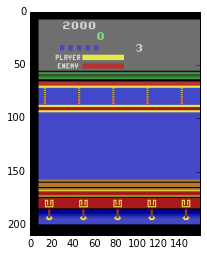

session # 0
 LEFT(qv = 0.0714285746217) -> 0.0 |  NOOP(qv = 0.274727851152) -> 0.0 |  UPRIGHTFIRE(qv = 0.170832276344) -> 0.0 |  DOWN(qv = 0.0437113754451) -> 0.0 |  LEFTFIRE(qv = 0.0234173256904) -> 0.0 |  LEFT(qv = 0.212572515011) -> 0.0 |  UPRIGHTFIRE(qv = 0.139860659838) -> 0.0 |  UPLEFTFIRE(qv = 0.0374152548611) -> 0.0 |  DOWNFIRE(qv = 0.0353923290968) -> 0.0 |  NOOP(qv = 0.208185002208) -> 0.0 |  UPLEFTFIRE(qv = 0.056246869266) -> 0.0 |  UPRIGHTFIRE(qv = 0.135110199451) -> 0.0 |  NOOP(qv = 0.177843317389) -> 0.0 |  LEFT(qv = 0.219183206558) -> 0.0 |  LEFT(qv = 0.141913667321) -> 0.0 |  NOOP(qv = 0.166359722614) -> 0.0 |  RIGHTFIRE(qv = 0.0364087410271) -> 0.0 |  NOOP(qv = 0.162783831358) -> 0.0 |  RIGHT(qv = 0.199787959456) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.146669447422) -> 0.0 |  LEFT(qv = 0.217208981514) -> 0.0 |  RIGHT(qv = 0.167164921761) -> 0.0 |  RIGHT(qv = 0.159370034933) -> 0.0 |  NOOP(qv = 0.105673342943) -> 0.0 |  UPRIGHTFIRE(qv = 0.192493990064) -> 0.0 | reached max sessi

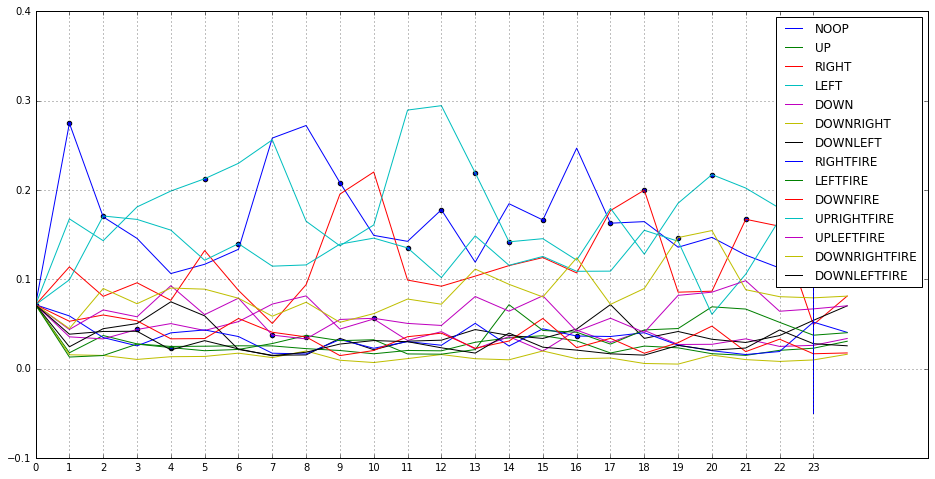

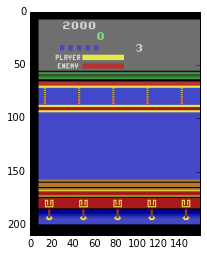

session # 0
 LEFT(qv = 0.0714285746217) -> 0.0 |  RIGHT(qv = 0.0770562365651) -> 0.0 |  NOOP(qv = 0.18153205514) -> 0.0 |  NOOP(qv = 0.218314453959) -> 0.0 |  RIGHTFIRE(qv = 0.030019139871) -> 0.0 |  LEFT(qv = 0.142637580633) -> 0.0 |  UPRIGHTFIRE(qv = 0.114916980267) -> 0.0 |  UP(qv = 0.0269349962473) -> 0.0 |  UPRIGHTFIRE(qv = 0.215023458004) -> 0.0 |  UPRIGHTFIRE(qv = 0.157071977854) -> 0.0 |  UPRIGHTFIRE(qv = 0.135205447674) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.115523040295) -> 0.0 |  NOOP(qv = 0.209984943271) -> 0.0 |  RIGHTFIRE(qv = 0.0299189388752) -> 0.0 |  NOOP(qv = 0.0683138072491) -> 0.0 |  NOOP(qv = 0.0893946662545) -> 0.0 |  UPRIGHTFIRE(qv = 0.185114189982) -> 0.0 |  NOOP(qv = 0.133094117045) -> 0.0 |  DOWNFIRE(qv = 0.0384965837002) -> 0.0 |  LEFT(qv = 0.145618394017) -> 0.0 |  UPRIGHTFIRE(qv = 0.210853978992) -> 0.0 |  NOOP(qv = 0.143933981657) -> 0.0 |  UPRIGHTFIRE(qv = 0.137273147702) -> 0.0 |  UPLEFTFIRE(qv = 0.0529298149049) -> 0.0 |  DOWNFIRE(qv = 0.0396251231432) -> 0.0 |

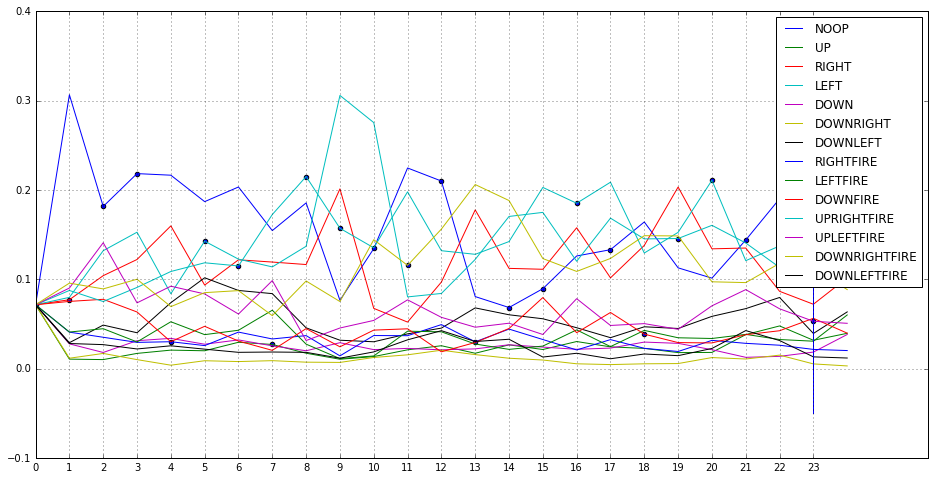

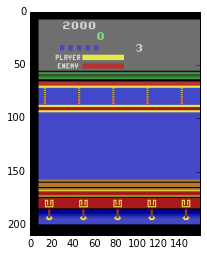

session # 0
 NOOP(qv = 0.0714285746217) -> 0.0 |  LEFT(qv = 0.132924214005) -> 0.0 |  UPLEFTFIRE(qv = 0.0308502167463) -> 0.0 |  LEFT(qv = 0.0804563090205) -> 0.0 |  LEFT(qv = 0.111467279494) -> 0.0 |  NOOP(qv = 0.148430049419) -> 0.0 |  UPRIGHTFIRE(qv = 0.138302281499) -> 0.0 |  LEFT(qv = 0.196398034692) -> 0.0 |  UPLEFTFIRE(qv = 0.0274015460163) -> 0.0 |  NOOP(qv = 0.183680638671) -> 0.0 |  RIGHT(qv = 0.0699832066894) -> 0.0 |  RIGHT(qv = 0.155819550157) -> 0.0 |  LEFT(qv = 0.139669254422) -> 0.0 |  LEFT(qv = 0.146802887321) -> 0.0 |  RIGHT(qv = 0.0616547390819) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.168343663216) -> 0.0 |  UPRIGHTFIRE(qv = 0.0952302515507) -> 0.0 |  NOOP(qv = 0.0689637362957) -> 0.0 |  LEFT(qv = 0.225361272693) -> 0.0 |  NOOP(qv = 0.123257301748) -> 0.0 |  DOWNFIRE(qv = 0.0608925893903) -> 0.0 |  DOWN(qv = 0.035176422447) -> 0.0 |  LEFT(qv = 0.264821201563) -> 0.0 |  LEFT(qv = 0.288654565811) -> 0.0 |  UPRIGHTFIRE(qv = 0.107119672) -> 0.0 | reached max session length


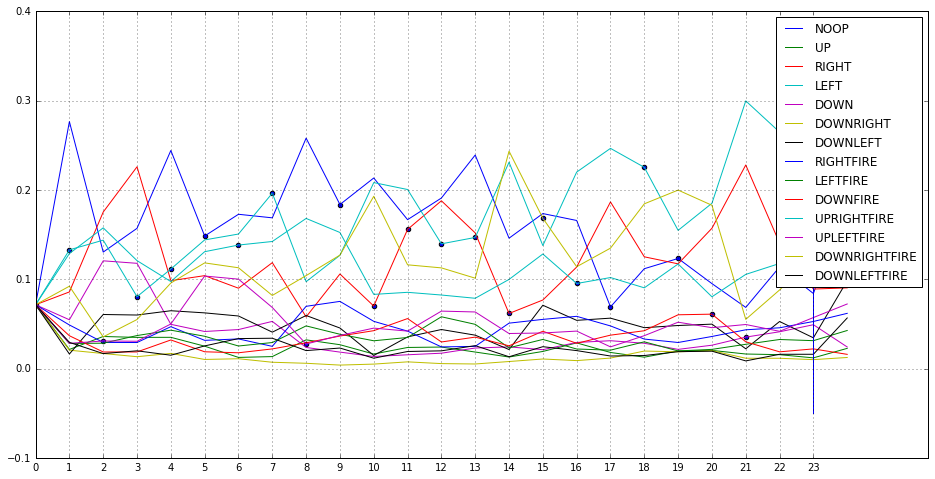

In [30]:
#visualize untrained network performance (which is mostly random)
display_sessions(with_plots=True)

# Training loop

In [31]:
#tools for model persistence (in progress now. Requires unique names)
from agentnet.utils.persistence import save,load
import os

In [32]:
from agentnet.display import Metrics
score_log = Metrics()

In [ ]:
#starting epoch
epoch_counter = 1
#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

epoch 50,loss 0.47229, epsilon 0.49109, rewards: ( e-greedy 0.00000, greedy 0.00000) 
rec -0.202 reg 0.675
epoch 100,loss 0.47542, epsilon 0.48236, rewards: ( e-greedy 0.00000, greedy 0.00000) 
rec -0.199 reg 0.674
epoch 150,loss 0.88023, epsilon 0.47379, rewards: ( e-greedy 0.00000, greedy 0.00000) 
rec 0.203 reg 0.677
epoch 200,loss 42.00722, epsilon 0.46540, rewards: ( e-greedy 1.00000, greedy 0.00000) 
rec 41.329 reg 0.678
epoch 250,loss 1.22193, epsilon 0.45718, rewards: ( e-greedy 0.90000, greedy 3.00000) 
rec 0.546 reg 0.676
epoch 300,loss 2.06227, epsilon 0.44911, rewards: ( e-greedy 0.81000, greedy 4.70000) 
rec 1.406 reg 0.656
epoch 350,loss 2.09043, epsilon 0.44121, rewards: ( e-greedy 0.72900, greedy 4.23000) 
rec 1.426 reg 0.664
epoch 400,loss 123.55732, epsilon 0.43346, rewards: ( e-greedy 1.65610, greedy 6.80700) 
rec 122.894 reg 0.663
epoch 450,loss 39.95736, epsilon 0.42587, rewards: ( e-greedy 2.49049, greedy 9.12630) 
rec 39.286 reg 0.671
epoch 500,loss 4.53736, epsi

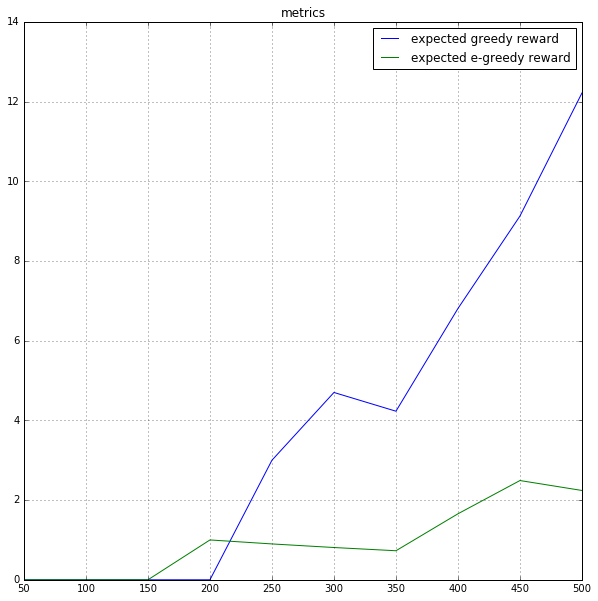

Random session examples


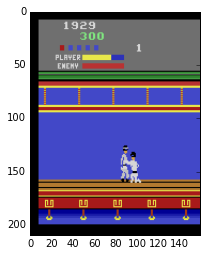

session # 0
 DOWNLEFT(qv = 0.0544504150748) -> 0.0 |  NOOP(qv = 0.0371490605175) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0637932643294) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0643041133881) -> 0.0 |  DOWN(qv = 0.125362172723) -> 0.0 |  DOWN(qv = 0.152657702565) -> 0.0 |  UP(qv = 0.0723327621818) -> 0.0 |  DOWN(qv = 0.13272960484) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.0563966333866) -> 0.0 |  UPRIGHTFIRE(qv = 0.0666308403015) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.0493501797318) -> 0.0 |  UP(qv = 0.0710246041417) -> 0.0 |  DOWNFIRE(qv = 0.0243202485144) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0505556873977) -> 0.0 |  LEFTFIRE(qv = 0.0677271038294) -> 0.0 |  RIGHT(qv = 0.358677148819) -> 0.0 |  UP(qv = 0.0361349023879) -> 0.0 |  LEFTFIRE(qv = 0.0784362927079) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.0287162084132) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.0495025403798) -> 0.0 |  RIGHTFIRE(qv = 0.0152012864128) -> 0.0 |  UPLEFTFIRE(qv = 0.0904364734888) -> 0.0 |  DOWN(qv = 0.0909946113825) -> 0.0 |  UP(qv = 0.0587562583387) -> 0.0 |  UPRIGHTFIRE(qv = 

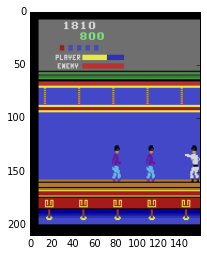

session # 0
 UPLEFTFIRE(qv = 0.0730153098702) -> 0.0 |  UPRIGHTFIRE(qv = 0.0941868200898) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.0332520194352) -> 0.0 |  DOWNRIGHT(qv = 0.0109367119148) -> 0.0 |  UPLEFTFIRE(qv = 0.0525740981102) -> 0.0 |  UP(qv = 0.0789841637015) -> 0.0 |  LEFT(qv = 0.0372875295579) -> 0.0 |  LEFT(qv = 0.0357914790511) -> 0.0 |  DOWN(qv = 0.116453275084) -> 0.0 |  RIGHT(qv = 0.426750361919) -> 0.0 |  UP(qv = 0.0540354773402) -> 0.0 |  LEFT(qv = 0.0302973072976) -> 0.0 |  RIGHT(qv = 0.329409003258) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0497470386326) -> 0.0 |  UPLEFTFIRE(qv = 0.0938172116876) -> 0.0 |  UP(qv = 0.0645530894399) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0666377320886) -> 0.0 |  RIGHT(qv = 0.306586354971) -> 0.0 |  UPRIGHTFIRE(qv = 0.118754431605) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0541983917356) -> 0.0 |  UPLEFTFIRE(qv = 0.0777254626155) -> 0.0 |  UPLEFTFIRE(qv = 0.0987246483564) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0537465028465) -> 0.0 |  LEFTFIRE(qv = 0.0509725958109) -> 0.0 |  DOWN(qv = 0.0

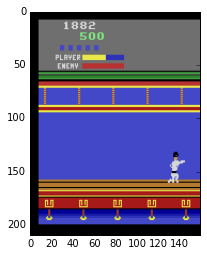

session # 0
 DOWNLEFTFIRE(qv = 0.0712655633688) -> 0.0 |  LEFT(qv = 0.0335314124823) -> 0.0 |  UPLEFTFIRE(qv = 0.0432283803821) -> 0.0 |  UPRIGHTFIRE(qv = 0.0995116308331) -> 0.0 |  NOOP(qv = 0.0290694888681) -> 0.0 |  DOWNFIRE(qv = 0.0304934084415) -> 0.0 |  RIGHTFIRE(qv = 0.0169911645353) -> 0.0 |  LEFTFIRE(qv = 0.0669534653425) -> 0.0 |  RIGHTFIRE(qv = 0.0128361517563) -> 0.0 |  UP(qv = 0.0476540848613) -> 0.0 |  LEFT(qv = 0.0440596975386) -> 0.0 |  RIGHT(qv = 0.433055460453) -> 0.0 |  DOWNRIGHT(qv = 0.0139740947634) -> 0.0 |  LEFT(qv = 0.0295693557709) -> 0.0 |  LEFTFIRE(qv = 0.0366976298392) -> 0.0 |  DOWN(qv = 0.0889641493559) -> 0.0 |  RIGHT(qv = 0.538660943508) -> 0.0 |  RIGHT(qv = 0.471128046513) -> 0.0 |  RIGHT(qv = 0.486955791712) -> 0.0 |  DOWN(qv = 0.0978944301605) -> 0.0 |  LEFTFIRE(qv = 0.056373462081) -> 0.0 |  UP(qv = 0.0441396571696) -> 0.0 |  DOWN(qv = 0.108359344304) -> 0.0 |  NOOP(qv = 0.0396456308663) -> 0.0 |  RIGHT(qv = 0.398786664009) -> 0.0 | reached max sessi

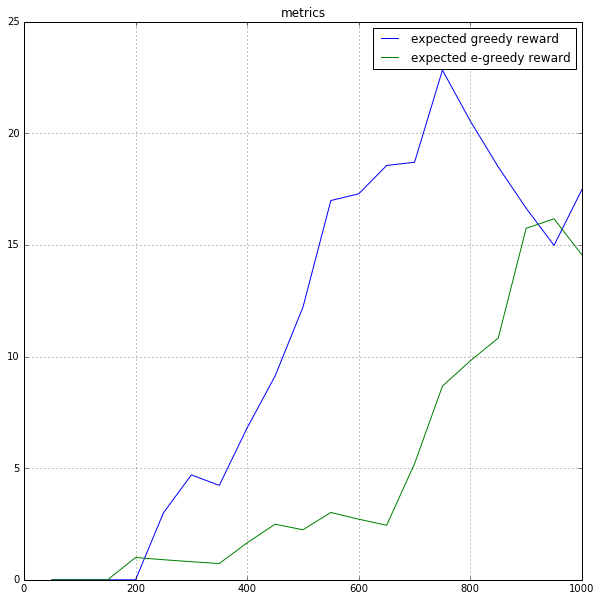

Random session examples


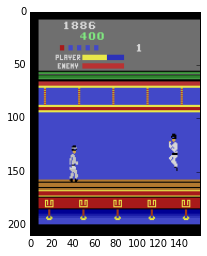

session # 0
 RIGHT(qv = 0.104505501688) -> 0.0 |  RIGHT(qv = 0.390211224556) -> 0.0 |  LEFTFIRE(qv = 0.0170852765441) -> 0.0 |  LEFTFIRE(qv = 0.0252205263823) -> 0.0 |  DOWN(qv = 0.03140379861) -> 0.0 |  RIGHT(qv = 0.296962887049) -> 0.0 |  LEFTFIRE(qv = 0.0313251838088) -> 0.0 |  RIGHT(qv = 0.346599668264) -> 0.0 |  UPLEFTFIRE(qv = 0.38430583477) -> 0.0 |  UP(qv = 0.0151162389666) -> 0.0 |  LEFT(qv = 0.0478131435812) -> 0.0 |  DOWN(qv = 0.0395004488528) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0892806872725) -> 0.0 |  RIGHT(qv = 0.263161182404) -> 0.0 |  UPLEFTFIRE(qv = 0.295128881931) -> 0.0 |  DOWNFIRE(qv = 0.0153166297823) -> 0.0 |  DOWN(qv = 0.0333361960948) -> 0.0 |  UPLEFTFIRE(qv = 0.248579874635) -> 0.0 |  DOWN(qv = 0.0423236563802) -> 0.0 |  UPLEFTFIRE(qv = 0.227218016982) -> 0.0 |  NOOP(qv = 0.0130609776825) -> 0.0 |  RIGHT(qv = 0.359765261412) -> 0.0 |  UPLEFTFIRE(qv = 0.342147618532) -> 0.0 |  RIGHT(qv = 0.35227689147) -> 0.0 |  RIGHT(qv = 0.28293672204) -> 0.0 | reached max session l

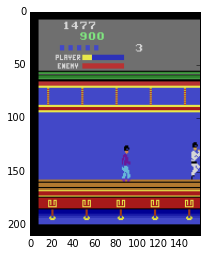

session # 0
 RIGHT(qv = 0.11387937516) -> 0.0 |  RIGHT(qv = 0.275654345751) -> 0.0 |  LEFT(qv = 0.0163065809757) -> 0.0 |  RIGHT(qv = 0.213368296623) -> 0.0 |  DOWN(qv = 0.0453899167478) -> 0.0 |  UPLEFTFIRE(qv = 0.390939950943) -> 0.0 |  UP(qv = 0.011077680625) -> 0.0 |  UP(qv = 0.0109869278967) -> 0.0 |  RIGHT(qv = 0.323621809483) -> 0.0 |  DOWNRIGHT(qv = 0.00301518011838) -> 0.0 |  RIGHT(qv = 0.372455954552) -> 0.0 |  UP(qv = 0.0125014130026) -> 0.0 |  UPLEFTFIRE(qv = 0.421114385128) -> 0.0 |  UP(qv = 0.0151055017486) -> 0.0 |  UP(qv = 0.0177608393133) -> 0.0 |  RIGHTFIRE(qv = 0.00149101018906) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0967864841223) -> 0.0 |  LEFTFIRE(qv = 0.0367494598031) -> 0.0 |  UPLEFTFIRE(qv = 0.316584557295) -> 0.0 |  DOWN(qv = 0.0211229771376) -> 0.0 |  RIGHT(qv = 0.337048947811) -> 0.0 |  LEFTFIRE(qv = 0.0357033647597) -> 0.0 |  RIGHT(qv = 0.305394470692) -> 0.0 |  UPLEFTFIRE(qv = 0.390807420015) -> 0.0 |  UPLEFTFIRE(qv = 0.33844268322) -> 0.0 | reached max session len

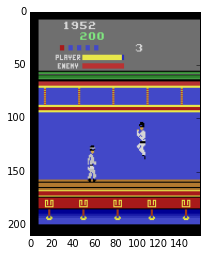

session # 0
 UP(qv = 0.0309637319297) -> 0.0 |  DOWNFIRE(qv = 0.0143893994391) -> 0.0 |  UPRIGHTFIRE(qv = 0.0214806776494) -> 0.0 |  RIGHT(qv = 0.296096742153) -> 0.0 |  UPLEFTFIRE(qv = 0.380720704794) -> 0.0 |  RIGHT(qv = 0.361852109432) -> 0.0 |  UPRIGHTFIRE(qv = 0.0639352872968) -> 0.0 |  NOOP(qv = 0.0125038549304) -> 0.0 |  DOWNLEFT(qv = 0.0022338158451) -> 0.0 |  RIGHT(qv = 0.470763683319) -> 0.0 |  UPRIGHTFIRE(qv = 0.0389978028834) -> 0.0 |  RIGHT(qv = 0.30999982357) -> 0.0 |  DOWN(qv = 0.0709257721901) -> 0.0 |  RIGHT(qv = 0.323897242546) -> 0.0 |  RIGHT(qv = 0.323897242546) -> 0.0 |  RIGHTFIRE(qv = 0.00310633983463) -> 0.0 |  RIGHT(qv = 0.356356441975) -> 0.0 |  UPRIGHTFIRE(qv = 0.023314550519) -> 0.0 |  RIGHT(qv = 0.137005597353) -> 0.0 |  RIGHT(qv = 0.187721073627) -> 0.0 |  NOOP(qv = 0.0183604285121) -> 0.0 |  RIGHT(qv = 0.382290780544) -> 0.0 |  UPRIGHTFIRE(qv = 0.0292311180383) -> 0.0 |  LEFT(qv = 0.0128371994942) -> 0.0 |  DOWN(qv = 0.0524486601353) -> 0.0 | reached max s

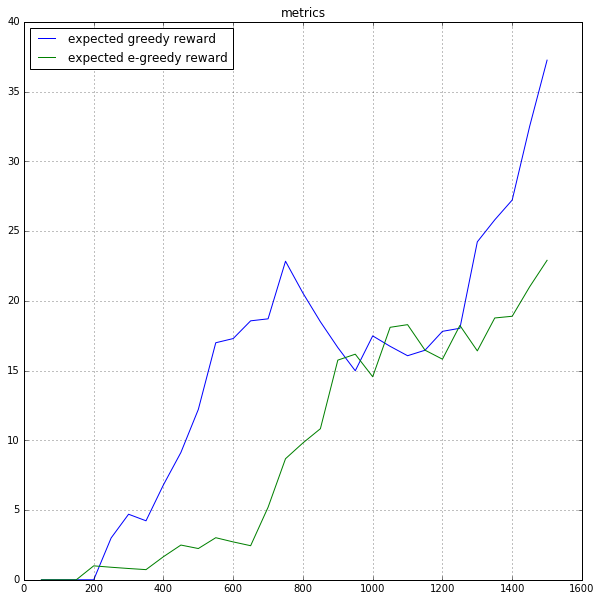

Random session examples


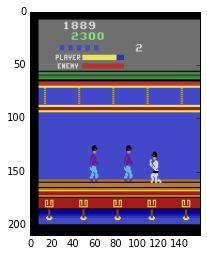

session # 0
 DOWNLEFTFIRE(qv = 0.10475178808) -> 0.0 |  DOWN(qv = 0.116549037397) -> 0.0 |  UPRIGHTFIRE(qv = 0.0363957285881) -> 0.0 |  DOWNLEFTFIRE(qv = 0.155829280615) -> 0.0 |  DOWNFIRE(qv = 0.0184456259012) -> 0.0 |  DOWN(qv = 0.109578087926) -> 0.0 |  UPLEFTFIRE(qv = 0.259861558676) -> 0.0 |  DOWNLEFTFIRE(qv = 0.111985631287) -> 0.0 |  DOWN(qv = 0.15474165976) -> 0.0 |  UPRIGHTFIRE(qv = 0.0303289424628) -> 0.0 |  UPLEFTFIRE(qv = 0.15397387743) -> 0.0 |  DOWNLEFTFIRE(qv = 0.161058500409) -> 0.0 |  NOOP(qv = 0.00482712732628) -> 0.0 |  LEFTFIRE(qv = 0.0182023271918) -> 0.0 |  UPLEFTFIRE(qv = 0.292510986328) -> 0.0 |  UPLEFTFIRE(qv = 0.307180136442) -> 0.0 |  RIGHT(qv = 0.173885002732) -> 0.0 |  DOWNLEFT(qv = 0.0227430742234) -> 0.0 |  UPLEFTFIRE(qv = 0.32673689723) -> 0.0 |  UPRIGHTFIRE(qv = 0.0192915610969) -> 0.0 |  UP(qv = 0.0141781587154) -> 0.0 |  UPLEFTFIRE(qv = 0.250558495522) -> 0.0 |  UPLEFTFIRE(qv = 0.236780539155) -> 0.0 |  UPLEFTFIRE(qv = 0.236780226231) -> 0.0 |  DOWN(q

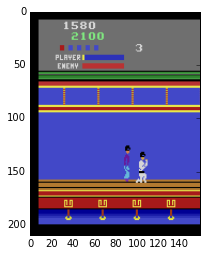

session # 0
 DOWN(qv = 0.116797871888) -> 0.0 |  DOWNLEFTFIRE(qv = 0.192031726241) -> 200.0 |  UPLEFTFIRE(qv = 0.219250351191) -> 0.0 |  LEFT(qv = 0.0994670018554) -> 0.0 |  RIGHT(qv = 0.171335294843) -> 0.0 |  LEFTFIRE(qv = 0.0459458492696) -> 0.0 |  UP(qv = 0.0125475628302) -> 0.0 |  LEFTFIRE(qv = 0.0415762960911) -> 0.0 |  DOWN(qv = 0.0838101506233) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0664388164878) -> 0.0 |  DOWNLEFT(qv = 0.0408143103123) -> 0.0 |  UPLEFTFIRE(qv = 0.277907013893) -> 0.0 |  UPLEFTFIRE(qv = 0.274069070816) -> 0.0 |  DOWN(qv = 0.069183409214) -> 0.0 |  DOWNFIRE(qv = 0.0148026496172) -> 0.0 |  RIGHT(qv = 0.260221213102) -> 0.0 |  DOWN(qv = 0.0923514589667) -> 0.0 |  DOWN(qv = 0.0867287293077) -> 0.0 |  UPLEFTFIRE(qv = 0.32802310586) -> 0.0 |  LEFT(qv = 0.14430129528) -> 0.0 |  RIGHT(qv = 0.296404868364) -> 0.0 |  LEFT(qv = 0.119155406952) -> 0.0 |  UPLEFTFIRE(qv = 0.20939438045) -> 0.0 |  LEFT(qv = 0.107255466282) -> 0.0 |  RIGHT(qv = 0.167412519455) -> 0.0 | reached max ses

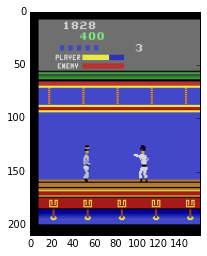

session # 0
 DOWNLEFT(qv = 0.0373612418771) -> 0.0 |  NOOP(qv = 0.00738288741559) -> 0.0 |  UPLEFTFIRE(qv = 0.336253792048) -> 0.0 |  RIGHT(qv = 0.233154714108) -> 0.0 |  UPLEFTFIRE(qv = 0.325477778912) -> 0.0 |  RIGHT(qv = 0.148044675589) -> 0.0 |  UPLEFTFIRE(qv = 0.287147939205) -> 0.0 |  RIGHT(qv = 0.209906101227) -> 0.0 |  DOWNFIRE(qv = 0.0152513841167) -> 0.0 |  DOWN(qv = 0.112936496735) -> 0.0 |  LEFT(qv = 0.10034199059) -> 0.0 |  UP(qv = 0.0078011136502) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0899030119181) -> 0.0 |  RIGHT(qv = 0.321092247963) -> 0.0 |  DOWNLEFTFIRE(qv = 0.129043370485) -> 0.0 |  DOWNRIGHT(qv = 0.0282911341637) -> 0.0 |  UPLEFTFIRE(qv = 0.31178611517) -> 0.0 |  UPRIGHTFIRE(qv = 0.0204497966915) -> 0.0 |  RIGHT(qv = 0.196780413389) -> 0.0 |  RIGHTFIRE(qv = 0.000633208255749) -> 0.0 |  DOWNLEFTFIRE(qv = 0.119987078011) -> 0.0 |  DOWNFIRE(qv = 0.00981195177883) -> 0.0 |  LEFTFIRE(qv = 0.0543852336705) -> 0.0 |  DOWNRIGHT(qv = 0.0326944068074) -> 0.0 |  UPLEFTFIRE(qv = 0.266

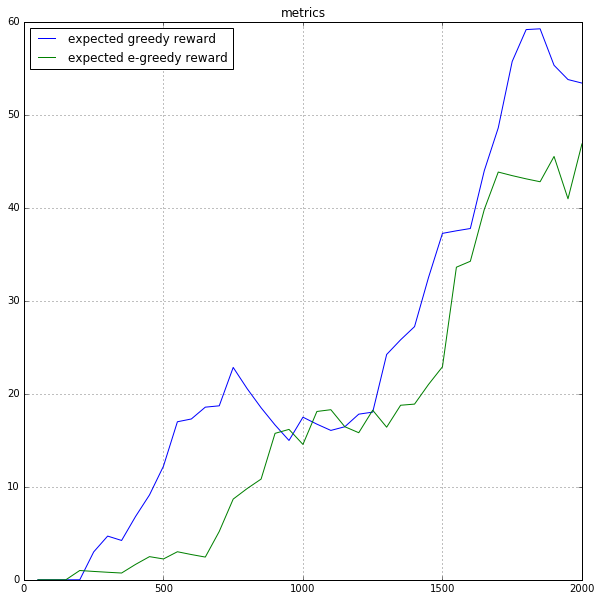

Random session examples


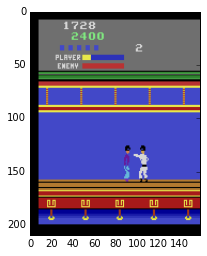

session # 0
 DOWNLEFTFIRE(qv = 0.178327485919) -> 0.0 |  UPLEFTFIRE(qv = 0.22808483243) -> 0.0 |  DOWN(qv = 0.136933505535) -> 0.0 |  LEFTFIRE(qv = 0.0481373630464) -> 0.0 |  DOWNLEFTFIRE(qv = 0.105071298778) -> 0.0 |  DOWNLEFT(qv = 0.0560490824282) -> 0.0 |  RIGHT(qv = 0.170266166329) -> 0.0 |  LEFT(qv = 0.105586849153) -> 0.0 |  DOWN(qv = 0.137524738908) -> 0.0 |  DOWNLEFT(qv = 0.0499375090003) -> 0.0 |  UPLEFTFIRE(qv = 0.247482046485) -> 0.0 |  DOWNFIRE(qv = 0.0126572949812) -> 0.0 |  DOWNFIRE(qv = 0.0126572949812) -> 0.0 |  NOOP(qv = 0.00359092629515) -> 0.0 |  DOWNLEFTFIRE(qv = 0.127247184515) -> 0.0 |  DOWNLEFTFIRE(qv = 0.123402364552) -> 0.0 |  UPLEFTFIRE(qv = 0.241520032287) -> 0.0 |  UPLEFTFIRE(qv = 0.197961479425) -> 0.0 |  LEFTFIRE(qv = 0.0455896817148) -> 0.0 |  UPLEFTFIRE(qv = 0.197961360216) -> 0.0 |  DOWNLEFTFIRE(qv = 0.123417183757) -> 0.0 |  DOWN(qv = 0.130788460374) -> 0.0 |  UPLEFTFIRE(qv = 0.197961360216) -> 0.0 |  DOWNLEFTFIRE(qv = 0.146850198507) -> 0.0 |  RIGHT(q

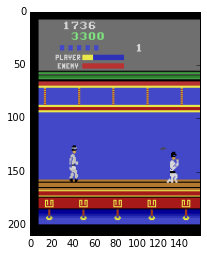

session # 0
 DOWNLEFTFIRE(qv = 0.167279049754) -> 0.0 |  DOWN(qv = 0.137269824743) -> 0.0 |  LEFTFIRE(qv = 0.0450828410685) -> 0.0 |  RIGHT(qv = 0.13776949048) -> 0.0 |  UPLEFTFIRE(qv = 0.261279016733) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.00281198672019) -> 0.0 |  DOWNLEFTFIRE(qv = 0.11667316407) -> 0.0 |  DOWN(qv = 0.147661238909) -> 0.0 |  DOWNRIGHT(qv = 0.0435873158276) -> 0.0 |  UPLEFTFIRE(qv = 0.247818127275) -> 0.0 |  DOWNFIRE(qv = 0.0194043293595) -> 0.0 |  DOWNLEFTFIRE(qv = 0.116678237915) -> 0.0 |  DOWNLEFTFIRE(qv = 0.116678237915) -> 0.0 |  LEFT(qv = 0.106028474867) -> 0.0 |  DOWN(qv = 0.173253938556) -> 0.0 |  UP(qv = 0.00957033969462) -> 0.0 |  DOWNLEFT(qv = 0.0720497891307) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0999835133553) -> 0.0 |  UPLEFTFIRE(qv = 0.293797761202) -> 0.0 |  LEFT(qv = 0.106487549841) -> 0.0 |  DOWN(qv = 0.172697156668) -> 0.0 |  DOWNRIGHT(qv = 0.0419009961188) -> 0.0 |  RIGHTFIRE(qv = 0.000336437340593) -> 0.0 |  RIGHT(qv = 0.127851843834) -> 0.0 |  UPLEFTFIRE(qv = 0.

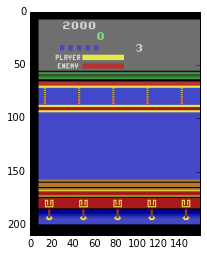

session # 0
 UPLEFTFIRE(qv = 0.278600841761) -> 0.0 |  DOWNLEFT(qv = 0.0547599121928) -> 0.0 |  RIGHT(qv = 0.122391201556) -> 0.0 |  UPLEFTFIRE(qv = 0.279868364334) -> 0.0 |  UPLEFTFIRE(qv = 0.279554843903) -> 0.0 |  RIGHT(qv = 0.139438852668) -> 0.0 |  DOWN(qv = 0.171562463045) -> 0.0 |  RIGHT(qv = 0.12243051827) -> 0.0 |  DOWNLEFTFIRE(qv = 0.114155501127) -> 0.0 |  LEFTFIRE(qv = 0.0529563836753) -> 0.0 |  LEFTFIRE(qv = 0.055540446192) -> 0.0 |  DOWN(qv = 0.145402237773) -> 0.0 |  LEFTFIRE(qv = 0.0546518415213) -> 0.0 |  UPLEFTFIRE(qv = 0.197856843472) -> 0.0 |  LEFTFIRE(qv = 0.050041757524) -> 0.0 |  NOOP(qv = 0.00401605246589) -> 0.0 |  UPLEFTFIRE(qv = 0.231347352266) -> 0.0 |  DOWNLEFTFIRE(qv = 0.135511294007) -> 0.0 |  UPLEFTFIRE(qv = 0.231347352266) -> 0.0 |  DOWN(qv = 0.144344300032) -> 0.0 |  RIGHT(qv = 0.158910289407) -> 0.0 |  UPLEFTFIRE(qv = 0.231347352266) -> 0.0 |  RIGHT(qv = 0.158910095692) -> 0.0 |  UPLEFTFIRE(qv = 0.222662270069) -> 0.0 |  DOWNLEFTFIRE(qv = 0.1557629853

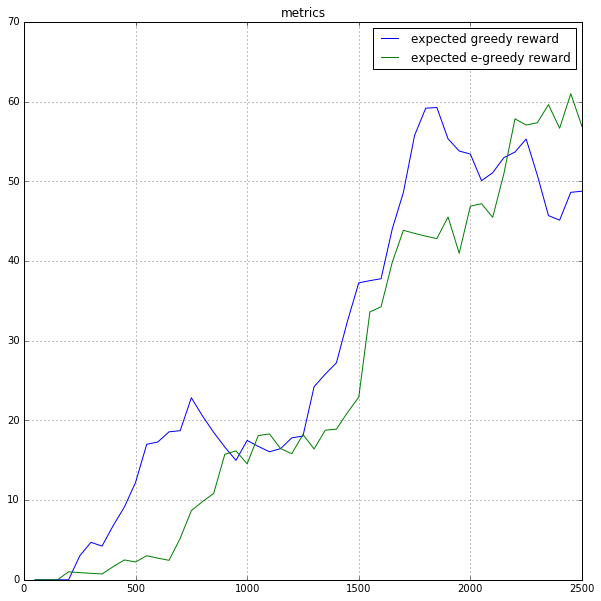

Random session examples


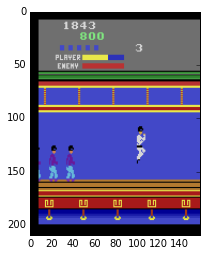

session # 0
 UPLEFTFIRE(qv = 0.278600782156) -> 0.0 |  DOWN(qv = 0.1436971277) -> 0.0 |  UPLEFTFIRE(qv = 0.381728768349) -> 0.0 |  RIGHT(qv = 0.119255542755) -> 0.0 |  UPRIGHTFIRE(qv = 0.0104156341404) -> 0.0 |  RIGHT(qv = 0.119303762913) -> 0.0 |  UPLEFTFIRE(qv = 0.341814517975) -> 0.0 |  UPLEFTFIRE(qv = 0.381153136492) -> 0.0 |  DOWNLEFTFIRE(qv = 0.107643842697) -> 0.0 |  RIGHT(qv = 0.119099028409) -> 0.0 |  DOWNRIGHT(qv = 0.0657594278455) -> 0.0 |  DOWN(qv = 0.1396664083) -> 0.0 |  UPLEFTFIRE(qv = 0.381153136492) -> 0.0 |  UPLEFTFIRE(qv = 0.381153136492) -> 0.0 |  RIGHT(qv = 0.119099028409) -> 0.0 |  UPLEFTFIRE(qv = 0.381153136492) -> 0.0 |  UP(qv = 0.0092981448397) -> 0.0 |  UPLEFTFIRE(qv = 0.348768770695) -> 0.0 |  DOWNLEFT(qv = 0.0450666956604) -> 0.0 |  LEFT(qv = 0.0573545619845) -> 0.0 |  DOWNRIGHT(qv = 0.0657594278455) -> 0.0 |  UPLEFTFIRE(qv = 0.381153136492) -> 0.0 |  UPLEFTFIRE(qv = 0.381153136492) -> 0.0 |  DOWN(qv = 0.1396664083) -> 0.0 |  RIGHT(qv = 0.11600779742) -> 0.0

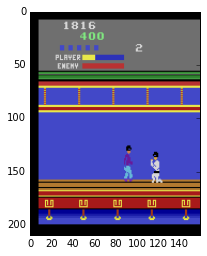

session # 0
 DOWN(qv = 0.139829307795) -> 0.0 |  DOWN(qv = 0.140614375472) -> 0.0 |  LEFT(qv = 0.0570671968162) -> 0.0 |  UPLEFTFIRE(qv = 0.377667158842) -> 0.0 |  DOWNRIGHT(qv = 0.0647905021906) -> 0.0 |  UPRIGHTFIRE(qv = 0.0105385724455) -> 200.0 |  UPLEFTFIRE(qv = 0.377608984709) -> 0.0 |  RIGHT(qv = 0.14526887238) -> 0.0 |  UPLEFTFIRE(qv = 0.353401362896) -> 0.0 |  DOWN(qv = 0.137597724795) -> 0.0 |  LEFT(qv = 0.0574837997556) -> 0.0 |  UPLEFTFIRE(qv = 0.376486033201) -> 0.0 |  DOWNLEFT(qv = 0.0454344265163) -> 0.0 |  UPLEFTFIRE(qv = 0.411604076624) -> 0.0 |  UPLEFTFIRE(qv = 0.411604076624) -> 0.0 |  DOWNFIRE(qv = 0.018826212734) -> 0.0 |  DOWN(qv = 0.141329318285) -> 0.0 |  UPLEFTFIRE(qv = 0.376486033201) -> 0.0 |  DOWNFIRE(qv = 0.018826212734) -> 0.0 |  UPLEFTFIRE(qv = 0.376486033201) -> 0.0 |  UPLEFTFIRE(qv = 0.376486033201) -> 0.0 |  DOWNRIGHT(qv = 0.0648005977273) -> 0.0 |  UPLEFTFIRE(qv = 0.376486033201) -> 0.0 |  RIGHT(qv = 0.122649118304) -> 0.0 |  DOWN(qv = 0.141329318285)

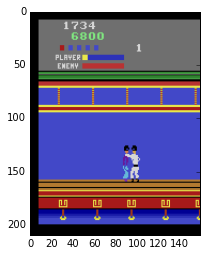

session # 0
 DOWNRIGHT(qv = 0.0408744215965) -> 0.0 |  UPLEFTFIRE(qv = 0.391019791365) -> 0.0 |  UPLEFTFIRE(qv = 0.389825880527) -> 0.0 |  DOWNLEFTFIRE(qv = 0.108379855752) -> 0.0 |  UPLEFTFIRE(qv = 0.38949200511) -> 0.0 |  RIGHT(qv = 0.113874696195) -> 0.0 |  RIGHT(qv = 0.113874696195) -> 0.0 |  UPLEFTFIRE(qv = 0.389103502035) -> 0.0 |  UPLEFTFIRE(qv = 0.389103502035) -> 0.0 |  DOWNFIRE(qv = 0.0195362363011) -> 0.0 |  DOWN(qv = 0.135172963142) -> 0.0 |  UPLEFTFIRE(qv = 0.388966470957) -> 0.0 |  DOWNLEFTFIRE(qv = 0.108588583767) -> 0.0 |  UPLEFTFIRE(qv = 0.420229136944) -> 0.0 |  UPLEFTFIRE(qv = 0.388966470957) -> 0.0 |  LEFT(qv = 0.0565981976688) -> 0.0 |  LEFT(qv = 0.0565981976688) -> 0.0 |  DOWNLEFT(qv = 0.044578820467) -> 0.0 |  DOWNLEFT(qv = 0.044578820467) -> 0.0 |  DOWNLEFT(qv = 0.044578820467) -> 0.0 |  DOWNRIGHT(qv = 0.0672257915139) -> 0.0 |  DOWN(qv = 0.13518358767) -> 0.0 |  DOWN(qv = 0.13518358767) -> 0.0 |  RIGHT(qv = 0.113902203739) -> 0.0 |  UPLEFTFIRE(qv = 0.3889664709

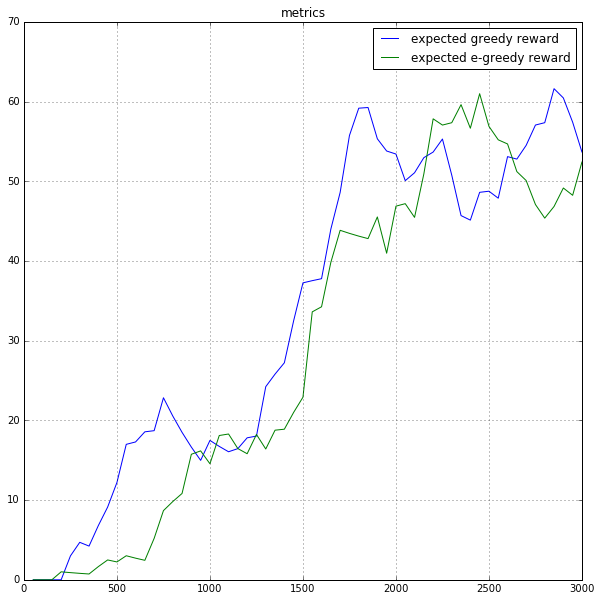

Random session examples


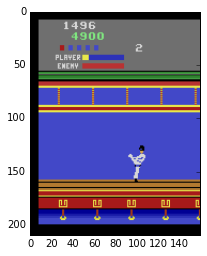

session # 0
 DOWNRIGHT(qv = 0.0752335116267) -> 0.0 |  DOWNRIGHT(qv = 0.0770382881165) -> 0.0 |  DOWNLEFTFIRE(qv = 0.136365622282) -> 0.0 |  DOWN(qv = 0.218850404024) -> 0.0 |  DOWN(qv = 0.218850135803) -> 0.0 |  UPLEFTFIRE(qv = 0.299921751022) -> 0.0 |  DOWNLEFT(qv = 0.045814409852) -> 0.0 |  DOWNLEFTFIRE(qv = 0.146152302623) -> 0.0 |  DOWNLEFT(qv = 0.045814409852) -> 0.0 |  DOWNRIGHT(qv = 0.0530131645501) -> 0.0 |  LEFT(qv = 0.0673489570618) -> 0.0 |  DOWNLEFTFIRE(qv = 0.152645841241) -> 0.0 |  DOWNLEFTFIRE(qv = 0.152645841241) -> 0.0 |  DOWNRIGHT(qv = 0.069535009563) -> 0.0 |  DOWN(qv = 0.217137604952) -> 0.0 |  UPLEFTFIRE(qv = 0.299867361784) -> 0.0 |  UPLEFTFIRE(qv = 0.299867361784) -> 0.0 |  DOWNLEFTFIRE(qv = 0.152630969882) -> 0.0 |  UPLEFTFIRE(qv = 0.299867361784) -> 0.0 |  UPLEFTFIRE(qv = 0.299867361784) -> 0.0 |  UPLEFTFIRE(qv = 0.299867361784) -> 0.0 |  DOWN(qv = 0.218903362751) -> 0.0 |  LEFTFIRE(qv = 0.0489531643689) -> 0.0 |  UPLEFTFIRE(qv = 0.299867361784) -> 0.0 |  LEFT

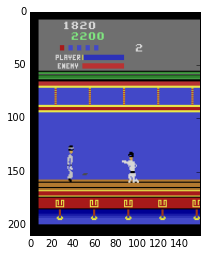

session # 0
 DOWNLEFTFIRE(qv = 0.19253501296) -> 0.0 |  UPLEFTFIRE(qv = 0.364244908094) -> 0.0 |  DOWN(qv = 0.21883174777) -> 0.0 |  DOWNFIRE(qv = 0.0144725255668) -> 0.0 |  RIGHT(qv = 0.0771742984653) -> 0.0 |  DOWNLEFTFIRE(qv = 0.152633473277) -> 0.0 |  DOWNRIGHT(qv = 0.0530056320131) -> 0.0 |  DOWNLEFT(qv = 0.0458270981908) -> 0.0 |  RIGHT(qv = 0.0769950076938) -> 0.0 |  UPLEFTFIRE(qv = 0.299919784069) -> 0.0 |  UPLEFTFIRE(qv = 0.299919784069) -> 0.0 |  LEFTFIRE(qv = 0.0489579252899) -> 0.0 |  DOWN(qv = 0.212895169854) -> 0.0 |  UPLEFTFIRE(qv = 0.299918979406) -> 0.0 |  LEFTFIRE(qv = 0.0489571653306) -> 0.0 |  DOWNLEFT(qv = 0.0458264797926) -> 0.0 |  LEFT(qv = 0.0673360675573) -> 0.0 |  DOWNLEFT(qv = 0.0458264797926) -> 0.0 |  DOWN(qv = 0.218851476908) -> 0.0 |  LEFTFIRE(qv = 0.0489571653306) -> 0.0 |  DOWN(qv = 0.218851476908) -> 0.0 |  UPLEFTFIRE(qv = 0.299919039011) -> 0.0 |  UPLEFTFIRE(qv = 0.299919039011) -> 0.0 |  LEFTFIRE(qv = 0.0489571653306) -> 0.0 |  DOWNLEFTFIRE(qv = 0.15

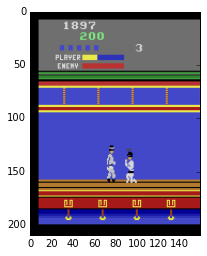

session # 0
 UPLEFTFIRE(qv = 0.281671315432) -> 0.0 |  UPLEFTFIRE(qv = 0.326608121395) -> 0.0 |  DOWNLEFTFIRE(qv = 0.194170862436) -> 0.0 |  UPLEFTFIRE(qv = 0.261291593313) -> 0.0 |  UPLEFTFIRE(qv = 0.28564363718) -> 0.0 |  RIGHT(qv = 0.0727042928338) -> 0.0 |  UPLEFTFIRE(qv = 0.284250259399) -> 0.0 |  DOWN(qv = 0.218920007348) -> 0.0 |  DOWN(qv = 0.218920007348) -> 0.0 |  DOWN(qv = 0.218956574798) -> 0.0 |  UPLEFTFIRE(qv = 0.299851149321) -> 0.0 |  RIGHT(qv = 0.0770386978984) -> 0.0 |  DOWNLEFTFIRE(qv = 0.152569025755) -> 0.0 |  UPLEFTFIRE(qv = 0.299851149321) -> 0.0 |  DOWNLEFT(qv = 0.0458293966949) -> 0.0 |  LEFT(qv = 0.0673693865538) -> 0.0 |  UPLEFTFIRE(qv = 0.299851149321) -> 0.0 |  DOWN(qv = 0.21895557642) -> 0.0 |  RIGHT(qv = 0.0770386978984) -> 0.0 |  UPLEFTFIRE(qv = 0.326131850481) -> 0.0 |  UPLEFTFIRE(qv = 0.326131850481) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.00361856957898) -> 0.0 |  RIGHT(qv = 0.0778830945492) -> 0.0 |  DOWNLEFT(qv = 0.0458267070353) -> 0.0 |  LEFT(qv = 0.0673463

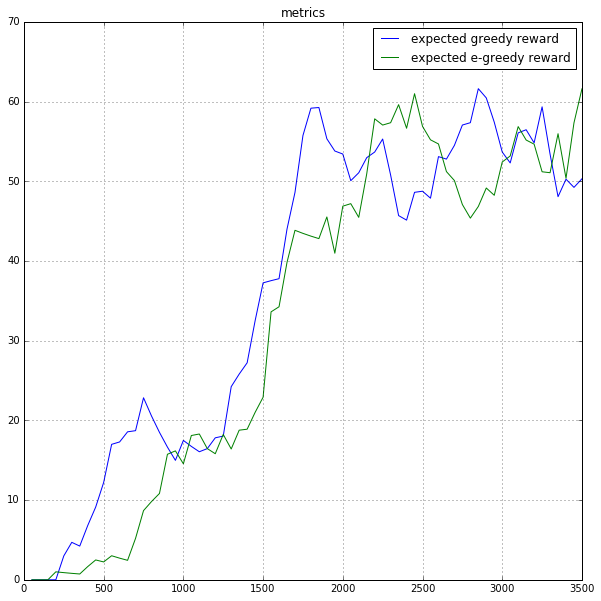

Random session examples


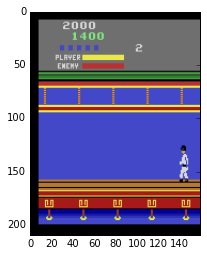

session # 0
 DOWNLEFT(qv = 0.059779420495) -> 0.0 |  DOWN(qv = 0.363793104887) -> 0.0 |  UPLEFTFIRE(qv = 0.268993645906) -> 0.0 |  RIGHT(qv = 0.0705794170499) -> 0.0 |  UPLEFTFIRE(qv = 0.268994420767) -> 0.0 |  LEFTFIRE(qv = 0.047073379159) -> 0.0 |  DOWNRIGHT(qv = 0.051409188658) -> 0.0 |  UPLEFTFIRE(qv = 0.300688683987) -> 0.0 |  DOWN(qv = 0.209786877036) -> 0.0 |  LEFTFIRE(qv = 0.0636546909809) -> 0.0 |  UPLEFTFIRE(qv = 0.268994182348) -> 0.0 |  UPLEFTFIRE(qv = 0.268994182348) -> 0.0 |  UPLEFTFIRE(qv = 0.30068847537) -> 0.0 |  DOWNFIRE(qv = 0.0253101568669) -> 0.0 |  DOWNLEFTFIRE(qv = 0.142571136355) -> 0.0 |  DOWNLEFTFIRE(qv = 0.18164665997) -> 0.0 |  DOWNLEFTFIRE(qv = 0.142571136355) -> 0.0 |  LEFT(qv = 0.0726035684347) -> 0.0 |  UPLEFTFIRE(qv = 0.360966026783) -> 0.0 |  LEFTFIRE(qv = 0.0470735095441) -> 0.0 |  LEFT(qv = 0.0716937482357) -> 0.0 |  DOWNLEFTFIRE(qv = 0.137158364058) -> 0.0 |  DOWNLEFTFIRE(qv = 0.137158155441) -> 0.0 |  LEFT(qv = 0.0714566558599) -> 0.0 |  UPLEFTFIRE

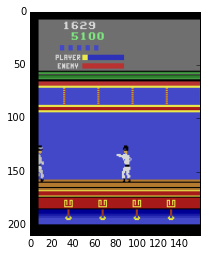

session # 0
 UPLEFTFIRE(qv = 0.215197011828) -> 0.0 |  UPLEFTFIRE(qv = 0.285354554653) -> 0.0 |  DOWNRIGHT(qv = 0.0514003150165) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.00292256707326) -> 0.0 |  RIGHT(qv = 0.0818368643522) -> 0.0 |  UPLEFTFIRE(qv = 0.27156829834) -> 0.0 |  DOWN(qv = 0.201725959778) -> 0.0 |  DOWN(qv = 0.201725959778) -> 0.0 |  UPLEFTFIRE(qv = 0.301585406065) -> 0.0 |  UPLEFTFIRE(qv = 0.301585406065) -> 0.0 |  DOWN(qv = 0.201300427318) -> 0.0 |  DOWN(qv = 0.201300427318) -> 0.0 |  UPLEFTFIRE(qv = 0.301585406065) -> 0.0 |  UPLEFTFIRE(qv = 0.301585406065) -> 0.0 |  DOWN(qv = 0.198698714375) -> 0.0 |  LEFTFIRE(qv = 0.0592449195683) -> 0.0 |  DOWNRIGHT(qv = 0.0531775802374) -> 0.0 |  DOWN(qv = 0.171534761786) -> 0.0 |  DOWN(qv = 0.171534761786) -> 0.0 |  UPLEFTFIRE(qv = 0.325366646051) -> 0.0 |  DOWN(qv = 0.201300412416) -> 0.0 |  DOWNLEFTFIRE(qv = 0.138575449586) -> 0.0 |  DOWN(qv = 0.201300412416) -> 0.0 |  UPLEFTFIRE(qv = 0.305568993092) -> 0.0 |  UPLEFTFIRE(qv = 0.301585435867) 

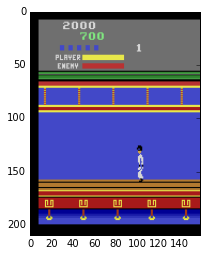

session # 0
 DOWN(qv = 0.16041366756) -> 0.0 |  DOWN(qv = 0.212109714746) -> 0.0 |  DOWN(qv = 0.212631553411) -> 0.0 |  DOWNRIGHT(qv = 0.0513888224959) -> 0.0 |  DOWN(qv = 0.172043412924) -> 0.0 |  UPLEFTFIRE(qv = 0.326117902994) -> 0.0 |  UPLEFTFIRE(qv = 0.302209556103) -> 0.0 |  UPLEFTFIRE(qv = 0.302209556103) -> 0.0 |  DOWN(qv = 0.199362546206) -> 0.0 |  UPLEFTFIRE(qv = 0.302209556103) -> 0.0 |  DOWN(qv = 0.201849132776) -> 0.0 |  UPLEFTFIRE(qv = 0.302209556103) -> 0.0 |  DOWN(qv = 0.201849132776) -> 0.0 |  UPLEFTFIRE(qv = 0.302209496498) -> 0.0 |  UPLEFTFIRE(qv = 0.32611784339) -> 0.0 |  DOWNLEFTFIRE(qv = 0.137220054865) -> 0.0 |  LEFT(qv = 0.0714498013258) -> 0.0 |  RIGHT(qv = 0.0818837359548) -> 0.0 |  RIGHT(qv = 0.0818837359548) -> 0.0 |  UPLEFTFIRE(qv = 0.302209496498) -> 0.0 |  UPLEFTFIRE(qv = 0.302209496498) -> 0.0 |  LEFT(qv = 0.0636740997434) -> 0.0 |  UPLEFTFIRE(qv = 0.271371930838) -> 0.0 |  UPLEFTFIRE(qv = 0.302209496498) -> 0.0 |  LEFTFIRE(qv = 0.0434862188995) -> 0.0 |

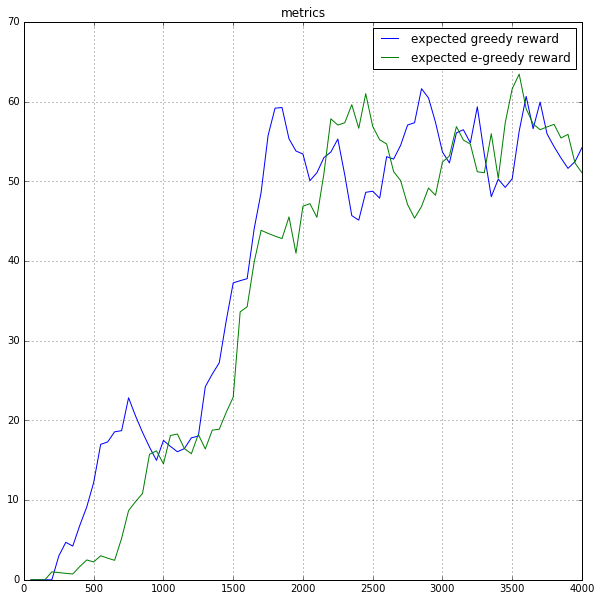

Random session examples


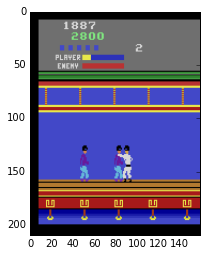

session # 0
 DOWN(qv = 0.150391176343) -> 0.0 |  LEFTFIRE(qv = 0.0415135025978) -> 0.0 |  UPLEFTFIRE(qv = 0.299913913012) -> 0.0 |  UPLEFTFIRE(qv = 0.299918532372) -> 0.0 |  DOWNRIGHT(qv = 0.0578242503107) -> 0.0 |  DOWN(qv = 0.175364673138) -> 0.0 |  DOWN(qv = 0.162738114595) -> 0.0 |  UPLEFTFIRE(qv = 0.296646207571) -> 0.0 |  DOWN(qv = 0.193133637309) -> 0.0 |  DOWN(qv = 0.18589219451) -> 0.0 |  UPLEFTFIRE(qv = 0.299000680447) -> 0.0 |  DOWNLEFTFIRE(qv = 0.167974948883) -> 0.0 |  DOWN(qv = 0.18589219451) -> 0.0 |  UPLEFTFIRE(qv = 0.299000680447) -> 0.0 |  DOWNLEFTFIRE(qv = 0.167974948883) -> 0.0 |  UPLEFTFIRE(qv = 0.299000680447) -> 0.0 |  UPLEFTFIRE(qv = 0.325939148664) -> 0.0 |  UPLEFTFIRE(qv = 0.299000680447) -> 0.0 |  DOWNLEFTFIRE(qv = 0.167974948883) -> 0.0 |  DOWN(qv = 0.18589219451) -> 0.0 |  DOWN(qv = 0.18589219451) -> 0.0 |  DOWNRIGHT(qv = 0.0535557866096) -> 0.0 |  DOWNLEFTFIRE(qv = 0.167974948883) -> 0.0 |  DOWNRIGHT(qv = 0.0535557866096) -> 0.0 |  DOWN(qv = 0.185892775655

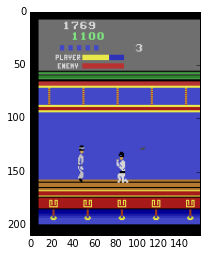

session # 0
 UPLEFTFIRE(qv = 0.242109701037) -> 0.0 |  DOWNLEFTFIRE(qv = 0.165281921625) -> 0.0 |  UPLEFTFIRE(qv = 0.299986988306) -> 0.0 |  LEFTFIRE(qv = 0.0415074639022) -> 0.0 |  DOWNLEFT(qv = 0.047973472625) -> 0.0 |  DOWNLEFTFIRE(qv = 0.16526915133) -> 0.0 |  UPLEFTFIRE(qv = 0.299986988306) -> 0.0 |  UPLEFTFIRE(qv = 0.299986988306) -> 0.0 |  DOWNLEFTFIRE(qv = 0.16526915133) -> 0.0 |  DOWNLEFTFIRE(qv = 0.16526915133) -> 0.0 |  DOWNLEFTFIRE(qv = 0.16526915133) -> 0.0 |  LEFT(qv = 0.0813404098153) -> 0.0 |  DOWNLEFTFIRE(qv = 0.16526915133) -> 0.0 |  UPLEFTFIRE(qv = 0.299986988306) -> 0.0 |  DOWN(qv = 0.207916066051) -> 0.0 |  DOWN(qv = 0.207916066051) -> 0.0 |  DOWN(qv = 0.207916066051) -> 0.0 |  LEFT(qv = 0.0801949873567) -> 0.0 |  UPLEFTFIRE(qv = 0.302686661482) -> 0.0 |  UPLEFTFIRE(qv = 0.302686661482) -> 0.0 |  DOWNLEFTFIRE(qv = 0.159633740783) -> 0.0 |  UPLEFTFIRE(qv = 0.302686661482) -> 0.0 |  DOWNLEFT(qv = 0.0657894015312) -> 0.0 |  RIGHT(qv = 0.0687151476741) -> 0.0 |  DOWNRI

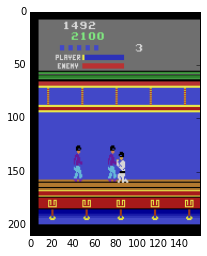

session # 0
 DOWNLEFTFIRE(qv = 0.286224156618) -> 0.0 |  UPLEFTFIRE(qv = 0.308414638042) -> 0.0 |  DOWNLEFTFIRE(qv = 0.197188138962) -> 0.0 |  LEFT(qv = 0.0803470090032) -> 0.0 |  DOWN(qv = 0.169132098556) -> 0.0 |  LEFT(qv = 0.0801886543632) -> 0.0 |  RIGHT(qv = 0.0686867013574) -> 0.0 |  DOWN(qv = 0.200425818563) -> 0.0 |  LEFT(qv = 0.0660726651549) -> 0.0 |  UPLEFTFIRE(qv = 0.285277694464) -> 0.0 |  DOWNLEFT(qv = 0.0657395198941) -> 0.0 |  DOWN(qv = 0.200429141521) -> 0.0 |  DOWNRIGHT(qv = 0.0743834152818) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.00147377536632) -> 0.0 |  UPLEFTFIRE(qv = 0.302702635527) -> 0.0 |  DOWNRIGHT(qv = 0.0602559261024) -> 0.0 |  DOWNLEFTFIRE(qv = 0.159565538168) -> 0.0 |  DOWNLEFTFIRE(qv = 0.159565538168) -> 0.0 |  LEFT(qv = 0.0801904127002) -> 0.0 |  DOWN(qv = 0.200425818563) -> 0.0 |  DOWNLEFTFIRE(qv = 0.159565538168) -> 0.0 |  DOWNLEFTFIRE(qv = 0.159565538168) -> 0.0 |  UPLEFTFIRE(qv = 0.302702635527) -> 0.0 |  DOWNLEFTFIRE(qv = 0.159565538168) -> 0.0 |  LEFTFIRE(

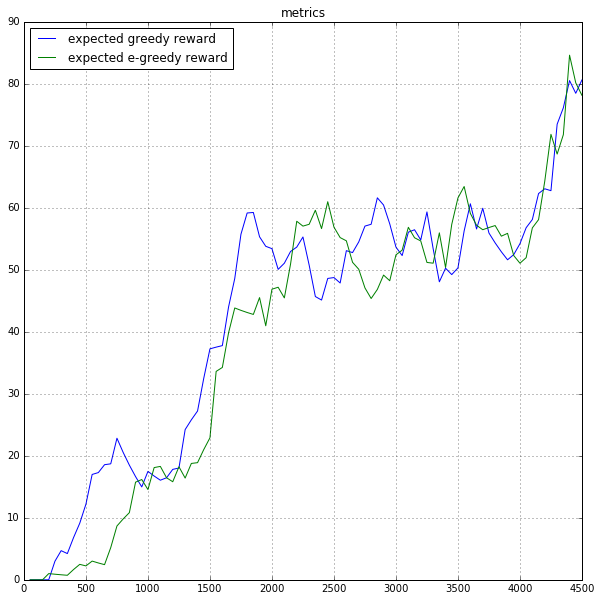

Random session examples


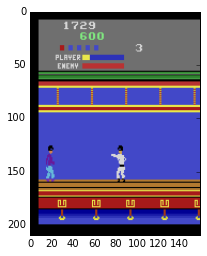

session # 0
 DOWN(qv = 0.121925383806) -> 0.0 |  LEFT(qv = 0.152941271663) -> 0.0 |  UPLEFTFIRE(qv = 0.316252350807) -> 0.0 |  UPLEFTFIRE(qv = 0.316252350807) -> 0.0 |  LEFT(qv = 0.143170043826) -> 0.0 |  UPLEFTFIRE(qv = 0.316252321005) -> 0.0 |  DOWNLEFTFIRE(qv = 0.179778814316) -> 0.0 |  DOWNRIGHT(qv = 0.0812192037702) -> 0.0 |  UPLEFTFIRE(qv = 0.316252321005) -> 0.0 |  UPLEFTFIRE(qv = 0.316252321005) -> 0.0 |  DOWN(qv = 0.149593278766) -> 0.0 |  DOWNLEFT(qv = 0.0401136688888) -> 0.0 |  LEFTFIRE(qv = 0.0297758877277) -> 0.0 |  UPLEFTFIRE(qv = 0.316252321005) -> 0.0 |  LEFT(qv = 0.161786779761) -> 0.0 |  UPLEFTFIRE(qv = 0.316252321005) -> 0.0 |  RIGHT(qv = 0.0343708507717) -> 0.0 |  UPLEFTFIRE(qv = 0.338416457176) -> 0.0 |  DOWNRIGHT(qv = 0.0812192037702) -> 200.0 |  UPLEFTFIRE(qv = 0.316252321005) -> 0.0 |  UPLEFTFIRE(qv = 0.316252321005) -> 0.0 |  DOWN(qv = 0.149593278766) -> 0.0 |  DOWN(qv = 0.149593278766) -> 0.0 |  DOWN(qv = 0.149593278766) -> 0.0 |  LEFT(qv = 0.143170043826) -> 

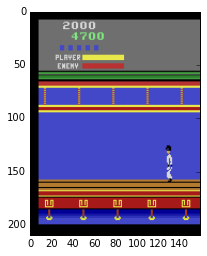

session # 0
 LEFT(qv = 0.119327642024) -> 0.0 |  DOWN(qv = 0.183250948787) -> 0.0 |  LEFT(qv = 0.145076930523) -> 0.0 |  UPLEFTFIRE(qv = 0.312155634165) -> 0.0 |  DOWN(qv = 0.155325457454) -> 0.0 |  UPLEFTFIRE(qv = 0.312155634165) -> 0.0 |  RIGHT(qv = 0.0391772277653) -> 0.0 |  UPLEFTFIRE(qv = 0.312155634165) -> 0.0 |  DOWN(qv = 0.155325457454) -> 0.0 |  RIGHT(qv = 0.0391772277653) -> 0.0 |  DOWNLEFTFIRE(qv = 0.185121104121) -> 0.0 |  DOWN(qv = 0.155325457454) -> 0.0 |  UPLEFTFIRE(qv = 0.312155634165) -> 0.0 |  UPLEFTFIRE(qv = 0.312155634165) -> 0.0 |  LEFTFIRE(qv = 0.0320068709552) -> 0.0 |  UPLEFTFIRE(qv = 0.312155634165) -> 0.0 |  DOWN(qv = 0.155325457454) -> 0.0 |  DOWNRIGHT(qv = 0.078581251204) -> 0.0 |  DOWNLEFTFIRE(qv = 0.185121104121) -> 0.0 |  LEFT(qv = 0.145076930523) -> 0.0 |  LEFTFIRE(qv = 0.0320068709552) -> 0.0 |  DOWNLEFTFIRE(qv = 0.185121104121) -> 0.0 |  DOWN(qv = 0.155325457454) -> 0.0 |  DOWNLEFTFIRE(qv = 0.185121104121) -> 0.0 |  UPLEFTFIRE(qv = 0.336041241884) -> 0

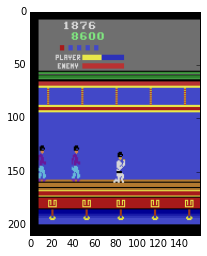

session # 0
 UPLEFTFIRE(qv = 0.225808337331) -> 0.0 |  UPLEFTFIRE(qv = 0.318788975477) -> 0.0 |  DOWN(qv = 0.154599815607) -> 0.0 |  UPLEFTFIRE(qv = 0.312330037355) -> 0.0 |  DOWNLEFTFIRE(qv = 0.185358718038) -> 0.0 |  UPLEFTFIRE(qv = 0.312330007553) -> 0.0 |  DOWNLEFT(qv = 0.0381481833756) -> 0.0 |  UPLEFTFIRE(qv = 0.312330007553) -> 0.0 |  DOWNLEFT(qv = 0.0381481833756) -> 0.0 |  DOWNLEFTFIRE(qv = 0.18535874784) -> 200.0 |  UPLEFTFIRE(qv = 0.336257725954) -> 0.0 |  DOWNLEFTFIRE(qv = 0.153168797493) -> 0.0 |  DOWNLEFTFIRE(qv = 0.18535874784) -> 0.0 |  UPLEFTFIRE(qv = 0.312330007553) -> 0.0 |  DOWNRIGHT(qv = 0.0786900296807) -> 0.0 |  LEFT(qv = 0.144840240479) -> 0.0 |  UPLEFTFIRE(qv = 0.312330007553) -> 0.0 |  UPLEFTFIRE(qv = 0.312330007553) -> 0.0 |  DOWNLEFTFIRE(qv = 0.18535874784) -> 0.0 |  DOWN(qv = 0.155040666461) -> 200.0 |  LEFT(qv = 0.144840240479) -> 0.0 |  UPLEFTFIRE(qv = 0.312330007553) -> 0.0 |  UPLEFTFIRE(qv = 0.312330007553) -> 0.0 |  UPLEFTFIRE(qv = 0.312330007553) -> 0

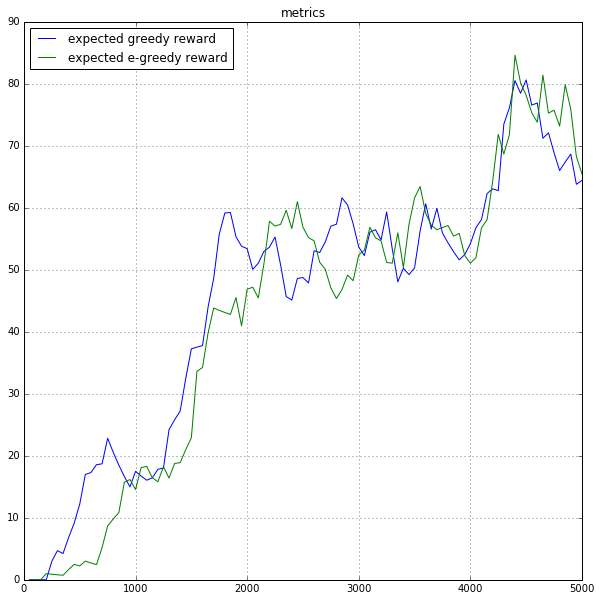

Random session examples


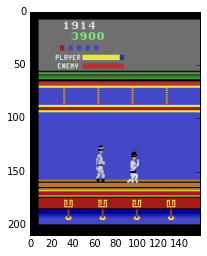

session # 0
 LEFTFIRE(qv = 0.0502628944814) -> 0.0 |  DOWNLEFTFIRE(qv = 0.163508549333) -> 0.0 |  UPLEFTFIRE(qv = 0.251077443361) -> 0.0 |  UPLEFTFIRE(qv = 0.23193231225) -> 0.0 |  DOWNLEFT(qv = 0.0540673658252) -> 0.0 |  LEFTFIRE(qv = 0.0448368042707) -> 0.0 |  DOWN(qv = 0.23516947031) -> 0.0 |  DOWNLEFTFIRE(qv = 0.186486154795) -> 0.0 |  UPLEFTFIRE(qv = 0.229762107134) -> 0.0 |  DOWN(qv = 0.216179147363) -> 0.0 |  DOWN(qv = 0.216179177165) -> 0.0 |  LEFTFIRE(qv = 0.0448368042707) -> 0.0 |  LEFT(qv = 0.0882820263505) -> 0.0 |  DOWNLEFT(qv = 0.0540673658252) -> 0.0 |  LEFTFIRE(qv = 0.0448368042707) -> 0.0 |  DOWNLEFTFIRE(qv = 0.186486154795) -> 0.0 |  RIGHT(qv = 0.0745122954249) -> 0.0 |  UPLEFTFIRE(qv = 0.229762107134) -> 0.0 |  LEFT(qv = 0.0882820263505) -> 0.0 |  DOWN(qv = 0.239590555429) -> 0.0 |  DOWN(qv = 0.21232663095) -> 0.0 |  DOWNLEFT(qv = 0.0540673658252) -> 0.0 |  LEFT(qv = 0.0882820263505) -> 0.0 |  DOWNLEFT(qv = 0.0540673658252) -> 0.0 |  UPLEFTFIRE(qv = 0.258928179741) -

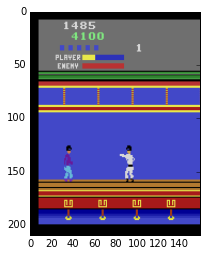

session # 0
 UP(qv = 0.00107708666474) -> 0.0 |  UPRIGHTFIRE(qv = 0.00486964732409) -> 0.0 |  DOWNLEFTFIRE(qv = 0.18752489984) -> 0.0 |  UPLEFTFIRE(qv = 0.210043296218) -> 0.0 |  DOWNRIGHT(qv = 0.062130831182) -> 0.0 |  LEFT(qv = 0.0902305841446) -> 0.0 |  DOWNRIGHT(qv = 0.0631847009063) -> 0.0 |  UPLEFTFIRE(qv = 0.260128945112) -> 0.0 |  LEFTFIRE(qv = 0.0447466149926) -> 0.0 |  DOWNRIGHT(qv = 0.0832568779588) -> 0.0 |  DOWNRIGHT(qv = 0.0639747753739) -> 0.0 |  LEFT(qv = 0.0892428532243) -> 0.0 |  DOWNLEFT(qv = 0.0541522204876) -> 0.0 |  DOWN(qv = 0.217300638556) -> 0.0 |  DOWN(qv = 0.217300638556) -> 0.0 |  DOWNLEFTFIRE(qv = 0.188471660018) -> 0.0 |  LEFT(qv = 0.0975636616349) -> 0.0 |  UPLEFTFIRE(qv = 0.230830326676) -> 0.0 |  DOWNLEFTFIRE(qv = 0.184133648872) -> 0.0 |  DOWNFIRE(qv = 0.0100847547874) -> 0.0 |  LEFTFIRE(qv = 0.0447466149926) -> 0.0 |  DOWNLEFTFIRE(qv = 0.184133648872) -> 0.0 |  UPLEFTFIRE(qv = 0.230830326676) -> 0.0 |  DOWN(qv = 0.240836367011) -> 0.0 |  UPLEFTFIRE(qv

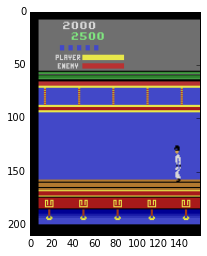

session # 0
 UPLEFTFIRE(qv = 0.205486923456) -> 0.0 |  DOWNLEFTFIRE(qv = 0.179231479764) -> 0.0 |  LEFTFIRE(qv = 0.0471797809005) -> 0.0 |  RIGHT(qv = 0.0638455748558) -> 0.0 |  DOWN(qv = 0.228938117623) -> 0.0 |  DOWNLEFT(qv = 0.0526841133833) -> 0.0 |  DOWN(qv = 0.251606494188) -> 0.0 |  DOWN(qv = 0.227420479059) -> 0.0 |  DOWN(qv = 0.227419868112) -> 0.0 |  DOWNLEFTFIRE(qv = 0.186846703291) -> 0.0 |  DOWNFIRE(qv = 0.0103016812354) -> 0.0 |  DOWN(qv = 0.243090331554) -> 0.0 |  LEFT(qv = 0.0939565971494) -> 0.0 |  UPLEFTFIRE(qv = 0.233561620116) -> 0.0 |  DOWN(qv = 0.243090331554) -> 0.0 |  LEFTFIRE(qv = 0.0438156276941) -> 0.0 |  DOWN(qv = 0.243090331554) -> 0.0 |  LEFT(qv = 0.0939565971494) -> 0.0 |  DOWN(qv = 0.243090331554) -> 0.0 |  DOWN(qv = 0.243090331554) -> 0.0 |  UPLEFTFIRE(qv = 0.233561620116) -> 0.0 |  DOWNRIGHT(qv = 0.0615844279528) -> 0.0 |  LEFT(qv = 0.102689638734) -> 0.0 |  UPLEFTFIRE(qv = 0.263137072325) -> 0.0 |  DOWNRIGHT(qv = 0.0615844279528) -> 0.0 | reached max 

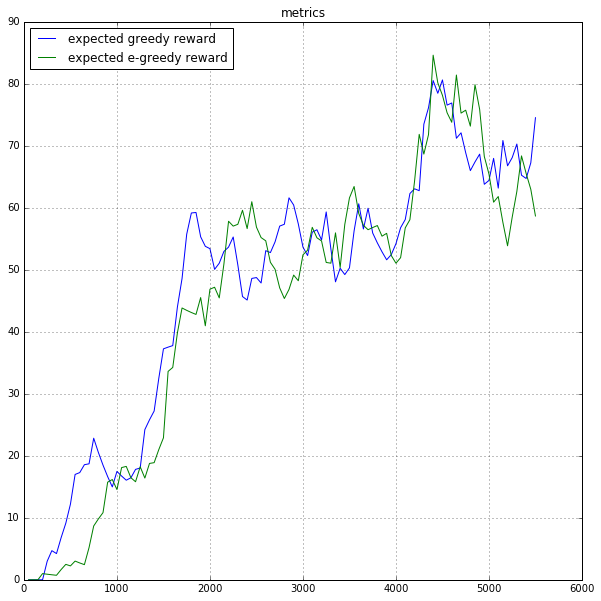

Random session examples


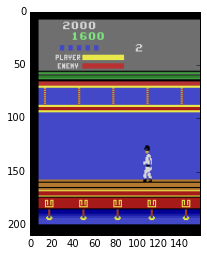

session # 0
 LEFT(qv = 0.137454077601) -> 0.0 |  LEFT(qv = 0.106635674834) -> 0.0 |  UPLEFTFIRE(qv = 0.314987540245) -> 0.0 |  UPLEFTFIRE(qv = 0.31497746706) -> 0.0 |  DOWNLEFT(qv = 0.0465405061841) -> 0.0 |  UPLEFTFIRE(qv = 0.31497746706) -> 0.0 |  DOWNLEFT(qv = 0.0465405061841) -> 0.0 |  RIGHT(qv = 0.0709553956985) -> 0.0 |  RIGHT(qv = 0.0709553956985) -> 0.0 |  UPLEFTFIRE(qv = 0.31497746706) -> 0.0 |  DOWN(qv = 0.215123802423) -> 0.0 |  LEFT(qv = 0.106617450714) -> 0.0 |  DOWNLEFTFIRE(qv = 0.171734064817) -> 0.0 |  RIGHT(qv = 0.0646723732352) -> 0.0 |  UPLEFTFIRE(qv = 0.291942834854) -> 0.0 |  RIGHT(qv = 0.0646723732352) -> 0.0 |  DOWNLEFTFIRE(qv = 0.171734064817) -> 0.0 |  DOWN(qv = 0.215123802423) -> 0.0 |  UPLEFTFIRE(qv = 0.31497746706) -> 0.0 |  UPLEFTFIRE(qv = 0.292219251394) -> 0.0 |  UPLEFTFIRE(qv = 0.291942834854) -> 0.0 |  DOWN(qv = 0.215123802423) -> 0.0 |  UPLEFTFIRE(qv = 0.31497746706) -> 0.0 |  UPLEFTFIRE(qv = 0.31497746706) -> 0.0 |  UPLEFTFIRE(qv = 0.31497746706) -> 0

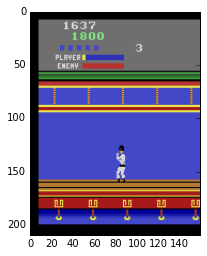

session # 0
 LEFT(qv = 0.139047682285) -> 0.0 |  DOWNLEFT(qv = 0.0353355444968) -> 0.0 |  LEFTFIRE(qv = 0.0346658304334) -> 0.0 |  DOWNRIGHT(qv = 0.0319075733423) -> 0.0 |  UPLEFTFIRE(qv = 0.304181843996) -> 0.0 |  DOWN(qv = 0.258900403976) -> 0.0 |  DOWN(qv = 0.258900403976) -> 0.0 |  DOWN(qv = 0.258900403976) -> 0.0 |  UPLEFTFIRE(qv = 0.304181843996) -> 0.0 |  LEFT(qv = 0.117836371064) -> 0.0 |  UPLEFTFIRE(qv = 0.289989948273) -> 0.0 |  LEFTFIRE(qv = 0.0346685647964) -> 0.0 |  UPLEFTFIRE(qv = 0.304181843996) -> 0.0 |  LEFTFIRE(qv = 0.0346685647964) -> 0.0 |  UPLEFTFIRE(qv = 0.304181843996) -> 0.0 |  DOWNLEFTFIRE(qv = 0.109562292695) -> 0.0 |  UPLEFTFIRE(qv = 0.304181843996) -> 0.0 |  RIGHT(qv = 0.0695218294859) -> 0.0 |  LEFT(qv = 0.117836371064) -> 0.0 |  DOWN(qv = 0.258900403976) -> 0.0 |  DOWN(qv = 0.258900403976) -> 0.0 |  DOWN(qv = 0.258900403976) -> 0.0 |  DOWN(qv = 0.258900403976) -> 0.0 |  DOWN(qv = 0.258900403976) -> 0.0 |  LEFT(qv = 0.131491392851) -> 0.0 | reached max sess

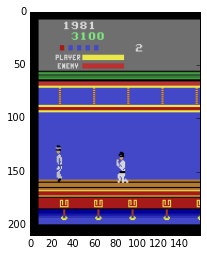

session # 0
 DOWNLEFT(qv = 0.0443290807307) -> 0.0 |  DOWN(qv = 0.223018676043) -> 0.0 |  LEFT(qv = 0.108113124967) -> 0.0 |  DOWN(qv = 0.223018720746) -> 0.0 |  DOWNLEFTFIRE(qv = 0.177393987775) -> 0.0 |  UPLEFTFIRE(qv = 0.311173915863) -> 0.0 |  LEFT(qv = 0.12068926543) -> 0.0 |  UPLEFTFIRE(qv = 0.314934968948) -> 0.0 |  RIGHT(qv = 0.0709957033396) -> 0.0 |  UPLEFTFIRE(qv = 0.314934968948) -> 0.0 |  DOWN(qv = 0.21498157084) -> 0.0 |  DOWN(qv = 0.21498157084) -> 0.0 |  UPLEFTFIRE(qv = 0.314934968948) -> 0.0 |  LEFT(qv = 0.106631666422) -> 0.0 |  DOWN(qv = 0.21498157084) -> 0.0 |  DOWNLEFTFIRE(qv = 0.171840831637) -> 0.0 |  DOWN(qv = 0.21498157084) -> 0.0 |  DOWN(qv = 0.21498157084) -> 0.0 |  DOWNLEFTFIRE(qv = 0.171840831637) -> 0.0 |  DOWNLEFTFIRE(qv = 0.171840831637) -> 0.0 |  DOWNLEFTFIRE(qv = 0.17805108428) -> 0.0 |  DOWN(qv = 0.214222952724) -> 0.0 |  LEFT(qv = 0.106631666422) -> 0.0 |  DOWN(qv = 0.21498157084) -> 0.0 |  LEFTFIRE(qv = 0.0269983299077) -> 0.0 | reached max session 

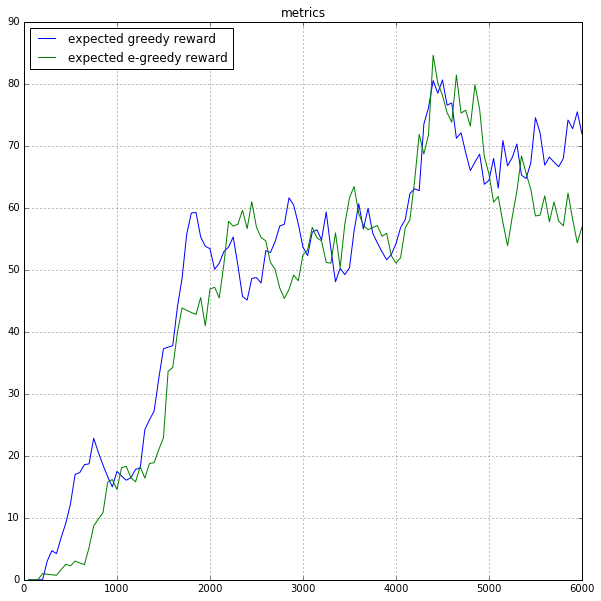

Random session examples


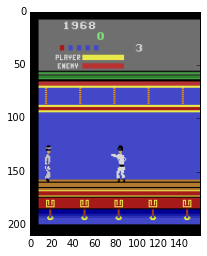

session # 0
 RIGHT(qv = 0.0369446389377) -> 0.0 |  UPLEFTFIRE(qv = 0.359054088593) -> 0.0 |  LEFT(qv = 0.0938235744834) -> 0.0 |  DOWN(qv = 0.281420499086) -> 0.0 |  DOWNLEFTFIRE(qv = 0.140876367688) -> 0.0 |  DOWNLEFT(qv = 0.0293585713953) -> 0.0 |  DOWNLEFTFIRE(qv = 0.140876367688) -> 0.0 |  LEFT(qv = 0.0938235744834) -> 0.0 |  DOWN(qv = 0.281420499086) -> 0.0 |  DOWNLEFTFIRE(qv = 0.140876367688) -> 0.0 |  DOWN(qv = 0.281420499086) -> 0.0 |  DOWN(qv = 0.281420499086) -> 0.0 |  DOWNLEFTFIRE(qv = 0.140876367688) -> 0.0 |  LEFT(qv = 0.0938235744834) -> 0.0 |  LEFT(qv = 0.0938235744834) -> 0.0 |  DOWNLEFTFIRE(qv = 0.140876367688) -> 0.0 |  LEFT(qv = 0.0938235744834) -> 0.0 |  DOWN(qv = 0.281420499086) -> 0.0 |  UPLEFTFIRE(qv = 0.359053939581) -> 0.0 |  DOWNLEFTFIRE(qv = 0.140876367688) -> 0.0 |  DOWN(qv = 0.281420499086) -> 0.0 |  UPLEFTFIRE(qv = 0.359053939581) -> 0.0 |  DOWNRIGHT(qv = 0.0249137990177) -> 0.0 |  UPLEFTFIRE(qv = 0.359053939581) -> 0.0 |  LEFT(qv = 0.0938235744834) -> 0.0

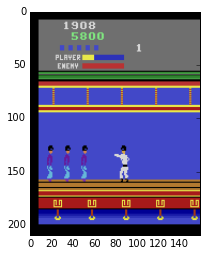

session # 0
 UPLEFTFIRE(qv = 0.311085343361) -> 0.0 |  LEFT(qv = 0.093833617866) -> 0.0 |  RIGHT(qv = 0.0415163300931) -> 0.0 |  DOWNFIRE(qv = 0.00646585877985) -> 0.0 |  UPLEFTFIRE(qv = 0.359052926302) -> 0.0 |  UPLEFTFIRE(qv = 0.359052926302) -> 0.0 |  UPLEFTFIRE(qv = 0.359052926302) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.000262348097749) -> 0.0 |  LEFT(qv = 0.0938297733665) -> 0.0 |  UPLEFTFIRE(qv = 0.359052926302) -> 0.0 |  LEFT(qv = 0.0938297733665) -> 0.0 |  UPLEFTFIRE(qv = 0.359052926302) -> 0.0 |  LEFT(qv = 0.0938297733665) -> 0.0 |  DOWN(qv = 0.281433820724) -> 0.0 |  LEFT(qv = 0.0938297733665) -> 0.0 |  DOWN(qv = 0.281433820724) -> 0.0 |  DOWN(qv = 0.281433820724) -> 0.0 |  DOWNLEFTFIRE(qv = 0.140865877271) -> 0.0 |  DOWN(qv = 0.281433820724) -> 0.0 |  DOWNLEFT(qv = 0.0293570999056) -> 0.0 |  DOWNRIGHT(qv = 0.0249124001712) -> 0.0 |  DOWNLEFTFIRE(qv = 0.146850064397) -> 0.0 |  DOWN(qv = 0.281433820724) -> 0.0 |  UPLEFTFIRE(qv = 0.359052926302) -> 0.0 |  DOWN(qv = 0.281433820724) -> 0

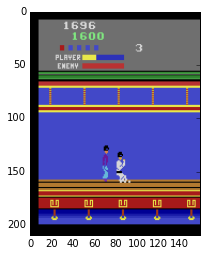

session # 0
 UPLEFTFIRE(qv = 0.31268197298) -> 0.0 |  DOWNLEFT(qv = 0.0293565560132) -> 200.0 |  DOWN(qv = 0.28142157197) -> 0.0 |  DOWN(qv = 0.28142157197) -> 0.0 |  DOWN(qv = 0.28142157197) -> 0.0 |  UPLEFTFIRE(qv = 0.359059631824) -> 0.0 |  UPLEFTFIRE(qv = 0.359059631824) -> 0.0 |  DOWNLEFTFIRE(qv = 0.140870839357) -> 0.0 |  LEFTFIRE(qv = 0.0194217618555) -> 0.0 |  UPLEFTFIRE(qv = 0.359059631824) -> 0.0 |  DOWN(qv = 0.28142157197) -> 0.0 |  UPLEFTFIRE(qv = 0.359059631824) -> 0.0 |  DOWNLEFTFIRE(qv = 0.140870839357) -> 0.0 |  DOWNLEFTFIRE(qv = 0.140870839357) -> 0.0 |  DOWN(qv = 0.28142157197) -> 0.0 |  DOWNLEFTFIRE(qv = 0.140870839357) -> 0.0 |  DOWN(qv = 0.28142157197) -> 0.0 |  DOWN(qv = 0.28142157197) -> 0.0 |  UPLEFTFIRE(qv = 0.269794821739) -> 0.0 |  DOWN(qv = 0.28142157197) -> 0.0 |  UPLEFTFIRE(qv = 0.359059631824) -> 0.0 |  DOWNLEFTFIRE(qv = 0.140870839357) -> 0.0 |  DOWN(qv = 0.28142157197) -> 0.0 |  LEFTFIRE(qv = 0.0194217618555) -> 0.0 |  DOWN(qv = 0.28142157197) -> 0.0 | 

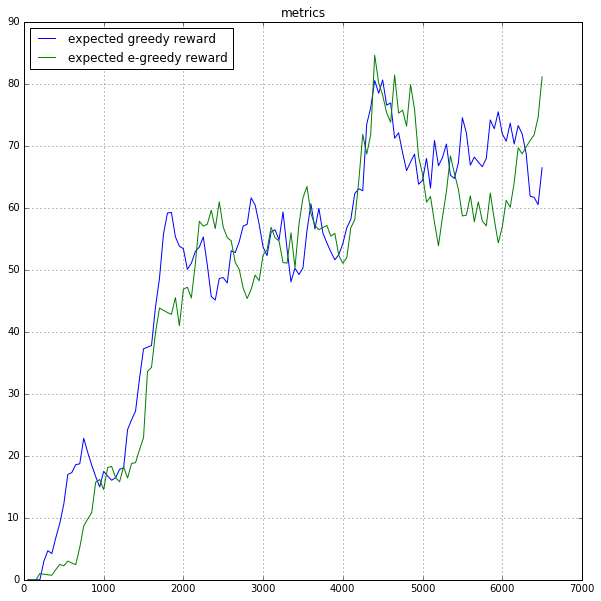

Random session examples


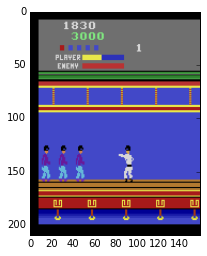

session # 0
 DOWN(qv = 0.232649505138) -> 0.0 |  RIGHT(qv = 0.0444599539042) -> 0.0 |  DOWNLEFTFIRE(qv = 0.176145076752) -> 0.0 |  UPLEFTFIRE(qv = 0.338750630617) -> 0.0 |  UPLEFTFIRE(qv = 0.338750630617) -> 0.0 |  UPLEFTFIRE(qv = 0.338750630617) -> 0.0 |  DOWNRIGHT(qv = 0.037077549845) -> 0.0 |  DOWNLEFTFIRE(qv = 0.176145076752) -> 0.0 |  RIGHT(qv = 0.0444599539042) -> 0.0 |  DOWN(qv = 0.27280908823) -> 0.0 |  DOWNLEFTFIRE(qv = 0.176145076752) -> 0.0 |  DOWNLEFTFIRE(qv = 0.176145076752) -> 0.0 |  UPLEFTFIRE(qv = 0.338750630617) -> 0.0 |  DOWNFIRE(qv = 0.00628605345264) -> 0.0 |  LEFTFIRE(qv = 0.0164219643921) -> 0.0 |  DOWN(qv = 0.27280908823) -> 0.0 |  LEFT(qv = 0.0770301446319) -> 0.0 |  UPLEFTFIRE(qv = 0.338750630617) -> 0.0 |  UPLEFTFIRE(qv = 0.338750630617) -> 0.0 |  UPLEFTFIRE(qv = 0.362700879574) -> 0.0 |  DOWNLEFT(qv = 0.0281309764832) -> 0.0 |  DOWN(qv = 0.271761953831) -> 0.0 |  DOWNLEFTFIRE(qv = 0.176145076752) -> 200.0 |  DOWN(qv = 0.27280908823) -> 0.0 |  DOWNLEFTFIRE(qv 

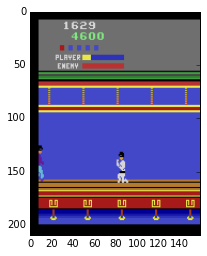

session # 0
 LEFT(qv = 0.0848902761936) -> 0.0 |  DOWNRIGHT(qv = 0.0370787493885) -> 0.0 |  DOWNRIGHT(qv = 0.0370787493885) -> 0.0 |  DOWN(qv = 0.272809952497) -> 0.0 |  UPLEFTFIRE(qv = 0.362678915262) -> 0.0 |  UPLEFTFIRE(qv = 0.362678915262) -> 0.0 |  UPLEFTFIRE(qv = 0.338729530573) -> 0.0 |  DOWNLEFT(qv = 0.0248211082071) -> 0.0 |  DOWN(qv = 0.272809952497) -> 0.0 |  UPLEFTFIRE(qv = 0.362678915262) -> 0.0 |  DOWNLEFTFIRE(qv = 0.176161944866) -> 0.0 |  UPLEFTFIRE(qv = 0.338729530573) -> 0.0 |  LEFT(qv = 0.0770246237516) -> 0.0 |  DOWNLEFTFIRE(qv = 0.176161944866) -> 0.0 |  UPLEFTFIRE(qv = 0.338729530573) -> 0.0 |  DOWN(qv = 0.272809952497) -> 0.0 |  DOWNLEFTFIRE(qv = 0.176161944866) -> 0.0 |  UPLEFTFIRE(qv = 0.362676978111) -> 0.0 |  DOWNLEFTFIRE(qv = 0.176161944866) -> 0.0 |  DOWN(qv = 0.272809952497) -> 0.0 |  DOWNLEFTFIRE(qv = 0.176161944866) -> 0.0 |  DOWN(qv = 0.272809952497) -> 0.0 |  UPLEFTFIRE(qv = 0.338729530573) -> 0.0 |  LEFT(qv = 0.0770246237516) -> 0.0 |  DOWNRIGHT(qv = 

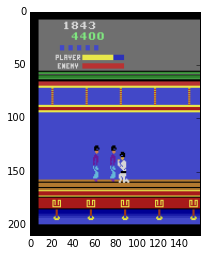

session # 0
 UPLEFTFIRE(qv = 0.301178514957) -> 0.0 |  LEFTFIRE(qv = 0.016426756978) -> 0.0 |  UPLEFTFIRE(qv = 0.338722795248) -> 0.0 |  UPLEFTFIRE(qv = 0.338722795248) -> 0.0 |  DOWN(qv = 0.272817611694) -> 0.0 |  DOWN(qv = 0.272817611694) -> 0.0 |  DOWN(qv = 0.272817611694) -> 0.0 |  DOWN(qv = 0.272817611694) -> 0.0 |  UPLEFTFIRE(qv = 0.362673044205) -> 0.0 |  DOWN(qv = 0.272817611694) -> 0.0 |  UPLEFTFIRE(qv = 0.362673044205) -> 0.0 |  DOWNLEFTFIRE(qv = 0.168844804168) -> 0.0 |  UPLEFTFIRE(qv = 0.362673044205) -> 0.0 |  DOWN(qv = 0.272817611694) -> 0.0 |  DOWNLEFT(qv = 0.0248199272901) -> 0.0 |  UPLEFTFIRE(qv = 0.338722795248) -> 0.0 |  UPLEFTFIRE(qv = 0.362673044205) -> 0.0 |  UPLEFTFIRE(qv = 0.338722795248) -> 0.0 |  UPLEFTFIRE(qv = 0.338722795248) -> 0.0 |  DOWNLEFTFIRE(qv = 0.168844804168) -> 0.0 |  DOWN(qv = 0.271771937609) -> 0.0 |  DOWNLEFTFIRE(qv = 0.168844804168) -> 0.0 |  DOWNLEFTFIRE(qv = 0.168844804168) -> 0.0 |  LEFTFIRE(qv = 0.016426756978) -> 0.0 |  UPLEFTFIRE(qv = 0.

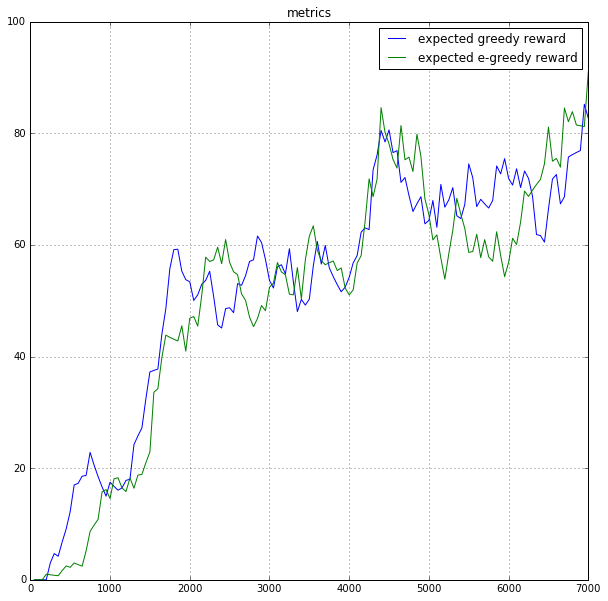

Random session examples


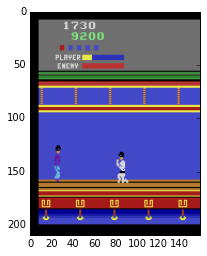

session # 0
 DOWN(qv = 0.210056424141) -> 0.0 |  DOWN(qv = 0.256401389837) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235171720386) -> 0.0 |  LEFT(qv = 0.083904363215) -> 0.0 |  UPLEFTFIRE(qv = 0.302700072527) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235171675682) -> 0.0 |  UPLEFTFIRE(qv = 0.302700072527) -> 0.0 |  UPLEFTFIRE(qv = 0.302700072527) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235171675682) -> 0.0 |  UPLEFTFIRE(qv = 0.302700072527) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235171675682) -> 0.0 |  DOWN(qv = 0.256400644779) -> 0.0 |  UPLEFTFIRE(qv = 0.280632793903) -> 0.0 |  DOWN(qv = 0.256400644779) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235171675682) -> 200.0 |  UPLEFTFIRE(qv = 0.302700072527) -> 0.0 |  UPLEFTFIRE(qv = 0.302700072527) -> 0.0 |  UPLEFTFIRE(qv = 0.302700072527) -> 0.0 |  DOWNRIGHT(qv = 0.0358427911997) -> 0.0 |  UPLEFTFIRE(qv = 0.302700072527) -> 0.0 |  UPLEFTFIRE(qv = 0.302700072527) -> 0.0 |  LEFT(qv = 0.083904363215) -> 0.0 |  DOWNLEFT(qv = 0.0323136411607) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235171675682) -> 0.0 |  UP

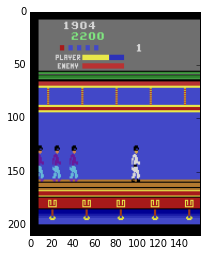

session # 0
 LEFT(qv = 0.079034678638) -> 0.0 |  UPLEFTFIRE(qv = 0.302802532911) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235087841749) -> 0.0 |  UPLEFTFIRE(qv = 0.280728697777) -> 0.0 |  UPLEFTFIRE(qv = 0.249127164483) -> 0.0 |  UPLEFTFIRE(qv = 0.302802532911) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235087841749) -> 0.0 |  DOWNLEFT(qv = 0.0323093570769) -> 0.0 |  LEFT(qv = 0.074802570045) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235087841749) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235087841749) -> 0.0 |  DOWN(qv = 0.256335109472) -> 200.0 |  DOWNLEFTFIRE(qv = 0.235087841749) -> 0.0 |  DOWNRIGHT(qv = 0.0358489304781) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235087841749) -> 0.0 |  UPLEFTFIRE(qv = 0.302802532911) -> 200.0 |  DOWN(qv = 0.256335109472) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235087841749) -> 0.0 |  UPLEFTFIRE(qv = 0.302802532911) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235087841749) -> 0.0 |  UPLEFTFIRE(qv = 0.302802532911) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235087841749) -> 0.0 |  DOWNLEFTFIRE(qv = 0.242317438126) -> 0.0 |  DOWNLEFT(qv = 0.028241

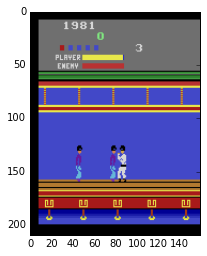

session # 0
 DOWN(qv = 0.209608927369) -> 0.0 |  DOWNRIGHT(qv = 0.0358427762985) -> 0.0 |  RIGHT(qv = 0.0438036434352) -> 0.0 |  DOWN(qv = 0.256400614977) -> 0.0 |  UPLEFTFIRE(qv = 0.302700042725) -> 0.0 |  DOWNRIGHT(qv = 0.035842794925) -> 0.0 |  DOWNLEFT(qv = 0.0323136672378) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235171690583) -> 0.0 |  DOWN(qv = 0.256400614977) -> 0.0 |  DOWNLEFT(qv = 0.0282451920211) -> 0.0 |  LEFT(qv = 0.0747750923038) -> 0.0 |  DOWN(qv = 0.256400614977) -> 0.0 |  UPLEFTFIRE(qv = 0.302700042725) -> 0.0 |  UPLEFTFIRE(qv = 0.302700042725) -> 0.0 |  RIGHT(qv = 0.0438036434352) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235171690583) -> 0.0 |  LEFT(qv = 0.0839043259621) -> 0.0 |  UPLEFTFIRE(qv = 0.302700042725) -> 0.0 |  LEFT(qv = 0.0839043259621) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235171690583) -> 0.0 |  UPLEFTFIRE(qv = 0.302700042725) -> 200.0 |  DOWN(qv = 0.256400614977) -> 0.0 |  UPLEFTFIRE(qv = 0.302700042725) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235171690583) -> 0.0 |  LEFT(qv = 0.074765920639)

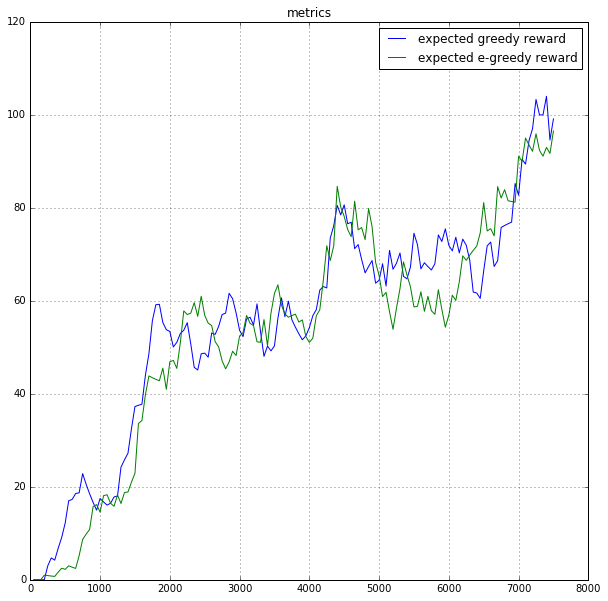

Random session examples


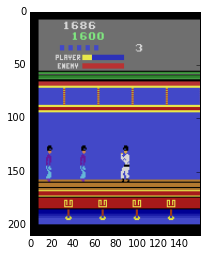

session # 0
 UPLEFTFIRE(qv = 0.229811131954) -> 0.0 |  DOWNLEFT(qv = 0.0282910410315) -> 0.0 |  LEFT(qv = 0.0903320163488) -> 0.0 |  DOWNLEFT(qv = 0.0282910410315) -> 0.0 |  DOWN(qv = 0.268485993147) -> 0.0 |  RIGHT(qv = 0.0415840819478) -> 0.0 |  DOWN(qv = 0.252385854721) -> 0.0 |  DOWN(qv = 0.252385854721) -> 0.0 |  DOWN(qv = 0.252385854721) -> 0.0 |  DOWN(qv = 0.252385854721) -> 0.0 |  DOWNLEFTFIRE(qv = 0.246517881751) -> 200.0 |  DOWNLEFTFIRE(qv = 0.246517881751) -> 0.0 |  LEFT(qv = 0.0903320163488) -> 0.0 |  LEFT(qv = 0.0903320163488) -> 0.0 |  DOWN(qv = 0.252385854721) -> 0.0 |  DOWN(qv = 0.252385854721) -> 0.0 |  DOWN(qv = 0.252385854721) -> 0.0 |  RIGHT(qv = 0.0415840819478) -> 0.0 |  DOWNLEFTFIRE(qv = 0.277030289173) -> 0.0 |  UPLEFTFIRE(qv = 0.191547289491) -> 200.0 |  DOWNLEFTFIRE(qv = 0.240283176303) -> 0.0 |  UPLEFTFIRE(qv = 0.287801891565) -> 0.0 |  UPLEFTFIRE(qv = 0.287801891565) -> 0.0 |  DOWNRIGHT(qv = 0.0437712669373) -> 0.0 |  UPLEFTFIRE(qv = 0.287801891565) -> 0.0 |

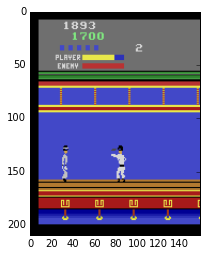

session # 0
 DOWNLEFTFIRE(qv = 0.342530399561) -> 0.0 |  UPLEFTFIRE(qv = 0.24049089849) -> 0.0 |  DOWNLEFTFIRE(qv = 0.24651812017) -> 0.0 |  DOWNRIGHT(qv = 0.0576774962246) -> 0.0 |  DOWNLEFTFIRE(qv = 0.24651812017) -> 0.0 |  DOWNRIGHT(qv = 0.0576774962246) -> 0.0 |  DOWNLEFT(qv = 0.0282911062241) -> 0.0 |  DOWN(qv = 0.255059719086) -> 0.0 |  DOWNLEFTFIRE(qv = 0.240283444524) -> 0.0 |  DOWNLEFT(qv = 0.0282911062241) -> 0.0 |  DOWN(qv = 0.255059719086) -> 0.0 |  DOWNLEFTFIRE(qv = 0.240283444524) -> 0.0 |  DOWN(qv = 0.252385914326) -> 0.0 |  DOWNLEFTFIRE(qv = 0.240283444524) -> 0.0 |  DOWNLEFTFIRE(qv = 0.240283444524) -> 0.0 |  DOWNLEFTFIRE(qv = 0.240283444524) -> 0.0 |  DOWN(qv = 0.255059719086) -> 0.0 |  DOWN(qv = 0.252385914326) -> 0.0 |  DOWN(qv = 0.255059719086) -> 0.0 |  UPLEFTFIRE(qv = 0.28780117631) -> 0.0 |  DOWNRIGHT(qv = 0.043771404773) -> 0.0 |  UPLEFTFIRE(qv = 0.28780117631) -> 0.0 |  DOWN(qv = 0.252385914326) -> 0.0 |  DOWN(qv = 0.252385914326) -> 0.0 |  UPLEFTFIRE(qv = 0.2

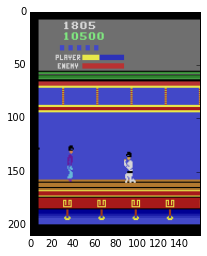

session # 0
 DOWNLEFTFIRE(qv = 0.342700511217) -> 0.0 |  LEFTFIRE(qv = 0.0120920957997) -> 0.0 |  DOWN(qv = 0.252385884523) -> 0.0 |  DOWNLEFT(qv = 0.0246012192219) -> 0.0 |  DOWN(qv = 0.252385884523) -> 0.0 |  UPLEFTFIRE(qv = 0.28780195117) -> 0.0 |  UPLEFTFIRE(qv = 0.265927046537) -> 0.0 |  DOWN(qv = 0.252385884523) -> 0.0 |  UPLEFTFIRE(qv = 0.265927046537) -> 0.0 |  DOWN(qv = 0.252385884523) -> 0.0 |  UPLEFTFIRE(qv = 0.265927046537) -> 0.0 |  DOWNLEFTFIRE(qv = 0.240283101797) -> 0.0 |  DOWNLEFTFIRE(qv = 0.27248519659) -> 0.0 |  UPLEFTFIRE(qv = 0.191547349095) -> 0.0 |  UPLEFTFIRE(qv = 0.265927046537) -> 0.0 |  DOWNLEFTFIRE(qv = 0.246517792344) -> 0.0 |  DOWN(qv = 0.252385884523) -> 0.0 |  UPLEFTFIRE(qv = 0.265927046537) -> 0.0 |  LEFT(qv = 0.09033203125) -> 0.0 |  DOWNLEFT(qv = 0.0246012192219) -> 0.0 |  DOWN(qv = 0.252385884523) -> 0.0 |  DOWNLEFTFIRE(qv = 0.240283101797) -> 0.0 |  DOWNLEFTFIRE(qv = 0.240283101797) -> 0.0 |  DOWN(qv = 0.255059659481) -> 0.0 |  DOWN(qv = 0.255059659

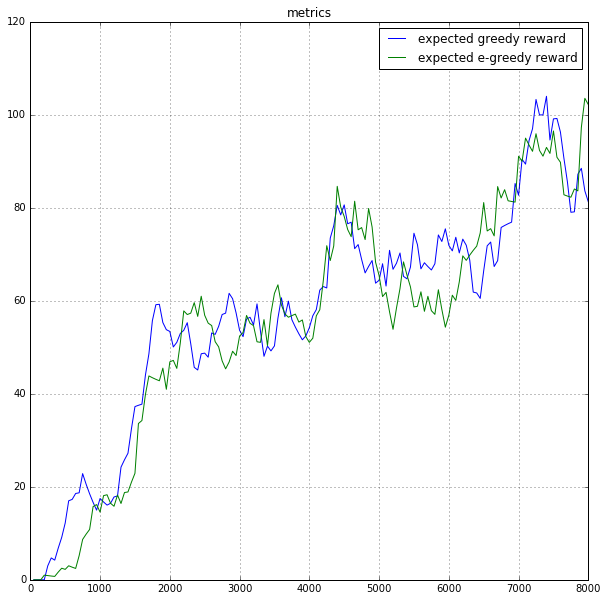

Random session examples


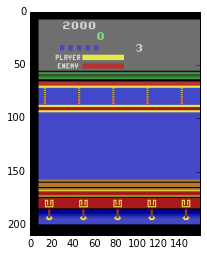

session # 0
 DOWNLEFTFIRE(qv = 0.410103499889) -> 0.0 |  LEFT(qv = 0.0786148756742) -> 0.0 |  LEFT(qv = 0.0786148756742) -> 0.0 |  DOWN(qv = 0.264586359262) -> 0.0 |  DOWNLEFTFIRE(qv = 0.302233636379) -> 0.0 |  DOWNLEFTFIRE(qv = 0.302233636379) -> 0.0 |  DOWN(qv = 0.264586359262) -> 0.0 |  UPLEFTFIRE(qv = 0.216599315405) -> 0.0 |  DOWN(qv = 0.264586359262) -> 0.0 |  UPLEFTFIRE(qv = 0.216599315405) -> 0.0 |  DOWNLEFT(qv = 0.021326713264) -> 0.0 |  LEFT(qv = 0.0876185372472) -> 0.0 |  UPLEFTFIRE(qv = 0.216599315405) -> 0.0 |  DOWNLEFTFIRE(qv = 0.302233636379) -> 0.0 |  DOWN(qv = 0.264586359262) -> 0.0 |  LEFT(qv = 0.0786148756742) -> 0.0 |  DOWN(qv = 0.264586359262) -> 0.0 |  UPLEFTFIRE(qv = 0.216599315405) -> 0.0 |  DOWN(qv = 0.264586359262) -> 0.0 |  LEFT(qv = 0.0876185372472) -> 0.0 |  UPLEFTFIRE(qv = 0.216599315405) -> 0.0 |  DOWNLEFT(qv = 0.021326713264) -> 0.0 |  DOWN(qv = 0.264586359262) -> 0.0 |  DOWN(qv = 0.264586359262) -> 0.0 |  DOWNLEFTFIRE(qv = 0.302233636379) -> 0.0 | reach

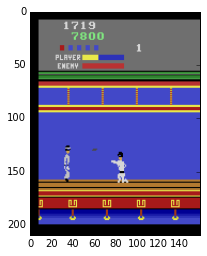

session # 0
 DOWNRIGHT(qv = 0.0461804233491) -> 0.0 |  DOWNLEFTFIRE(qv = 0.302234053612) -> 0.0 |  DOWNLEFTFIRE(qv = 0.302234053612) -> 0.0 |  DOWNLEFTFIRE(qv = 0.302234053612) -> 0.0 |  LEFT(qv = 0.0786149650812) -> 0.0 |  DOWNLEFTFIRE(qv = 0.302234053612) -> 0.0 |  DOWN(qv = 0.26458722353) -> 0.0 |  DOWN(qv = 0.26458722353) -> 0.0 |  LEFT(qv = 0.0786149650812) -> 0.0 |  LEFT(qv = 0.0786149650812) -> 0.0 |  DOWNLEFTFIRE(qv = 0.302234053612) -> 0.0 |  DOWN(qv = 0.26458722353) -> 0.0 |  DOWNLEFTFIRE(qv = 0.302234053612) -> 0.0 |  UPLEFTFIRE(qv = 0.216598987579) -> 0.0 |  UPLEFTFIRE(qv = 0.216598987579) -> 0.0 |  DOWN(qv = 0.26458722353) -> 0.0 |  UPLEFTFIRE(qv = 0.216598987579) -> 0.0 |  UPLEFTFIRE(qv = 0.216598987579) -> 0.0 |  DOWN(qv = 0.26458722353) -> 0.0 |  RIGHT(qv = 0.0376118384302) -> 0.0 |  DOWNLEFT(qv = 0.0213265810162) -> 0.0 |  DOWNLEFTFIRE(qv = 0.302234053612) -> 0.0 |  DOWNLEFTFIRE(qv = 0.302234053612) -> 0.0 |  DOWN(qv = 0.26458722353) -> 0.0 |  DOWNLEFTFIRE(qv = 0.30223

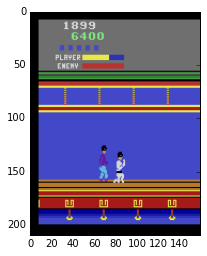

session # 0
 DOWN(qv = 0.209405004978) -> 0.0 |  DOWN(qv = 0.268641620874) -> 0.0 |  DOWNLEFTFIRE(qv = 0.302233964205) -> 0.0 |  DOWNLEFTFIRE(qv = 0.302233964205) -> 0.0 |  DOWN(qv = 0.26458722353) -> 0.0 |  UPLEFTFIRE(qv = 0.216598987579) -> 0.0 |  RIGHT(qv = 0.0376118570566) -> 0.0 |  DOWNRIGHT(qv = 0.0634235069156) -> 0.0 |  UPLEFTFIRE(qv = 0.216598987579) -> 0.0 |  LEFT(qv = 0.0786150023341) -> 0.0 |  DOWNRIGHT(qv = 0.0634235069156) -> 0.0 |  DOWN(qv = 0.26458722353) -> 0.0 |  DOWNLEFTFIRE(qv = 0.302233964205) -> 0.0 |  UPLEFTFIRE(qv = 0.216598987579) -> 0.0 |  DOWNLEFTFIRE(qv = 0.302233964205) -> 0.0 |  DOWN(qv = 0.346670240164) -> 0.0 |  DOWN(qv = 0.26458722353) -> 0.0 |  UPLEFTFIRE(qv = 0.216598987579) -> 0.0 |  DOWN(qv = 0.26458722353) -> 0.0 |  DOWNLEFTFIRE(qv = 0.302233964205) -> 0.0 |  UPLEFTFIRE(qv = 0.216598987579) -> 0.0 |  DOWNRIGHT(qv = 0.0634235069156) -> 0.0 |  DOWNLEFTFIRE(qv = 0.302233964205) -> 0.0 |  LEFT(qv = 0.0786150023341) -> 0.0 |  UPLEFTFIRE(qv = 0.216598987

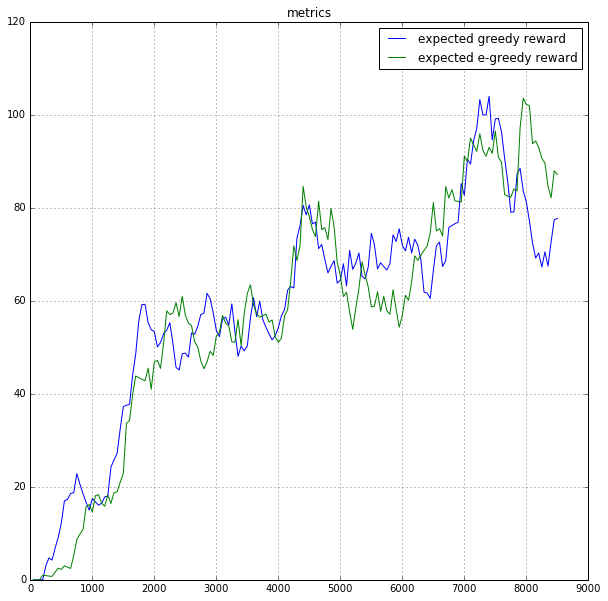

Random session examples


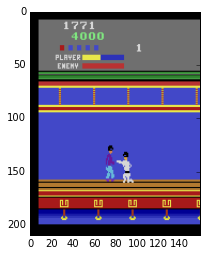

session # 0
 DOWNLEFTFIRE(qv = 0.474987447262) -> 200.0 |  DOWNLEFT(qv = 0.0324201248586) -> 0.0 |  DOWNLEFTFIRE(qv = 0.423024833202) -> 0.0 |  DOWNLEFTFIRE(qv = 0.453027456999) -> 0.0 |  UPLEFTFIRE(qv = 0.115531899035) -> 0.0 |  DOWNLEFTFIRE(qv = 0.453027456999) -> 0.0 |  DOWNRIGHT(qv = 0.0677150934935) -> 0.0 |  DOWNLEFTFIRE(qv = 0.453027456999) -> 0.0 |  DOWNRIGHT(qv = 0.0599147900939) -> 0.0 |  UPLEFTFIRE(qv = 0.167794466019) -> 0.0 |  DOWNLEFTFIRE(qv = 0.423024833202) -> 0.0 |  DOWNLEFTFIRE(qv = 0.423024833202) -> 0.0 |  DOWNLEFTFIRE(qv = 0.453027456999) -> 0.0 |  UPLEFTFIRE(qv = 0.115531899035) -> 0.0 |  DOWNRIGHT(qv = 0.0677150934935) -> 0.0 |  LEFT(qv = 0.0753722414374) -> 0.0 |  DOWN(qv = 0.169989824295) -> 0.0 |  DOWNLEFTFIRE(qv = 0.423024833202) -> 0.0 |  DOWNLEFTFIRE(qv = 0.423024833202) -> 0.0 |  DOWNLEFTFIRE(qv = 0.423024833202) -> 0.0 |  DOWNRIGHT(qv = 0.0599147900939) -> 0.0 |  RIGHT(qv = 0.0626412853599) -> 0.0 |  DOWN(qv = 0.17268165946) -> 0.0 |  DOWN(qv = 0.17268165

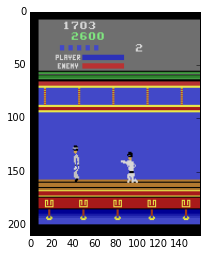

session # 0
 DOWNLEFTFIRE(qv = 0.415500938892) -> 0.0 |  DOWN(qv = 0.169987231493) -> 0.0 |  RIGHT(qv = 0.0626440644264) -> 0.0 |  DOWN(qv = 0.169987231493) -> 0.0 |  DOWNLEFTFIRE(qv = 0.405974924564) -> 0.0 |  DOWNRIGHT(qv = 0.0677161514759) -> 0.0 |  DOWNLEFTFIRE(qv = 0.45302015543) -> 0.0 |  DOWNLEFTFIRE(qv = 0.45302015543) -> 0.0 |  DOWNLEFTFIRE(qv = 0.423017531633) -> 0.0 |  DOWN(qv = 0.169987231493) -> 0.0 |  DOWN(qv = 0.169987231493) -> 0.0 |  DOWNRIGHT(qv = 0.0677161514759) -> 0.0 |  DOWNRIGHT(qv = 0.0677161514759) -> 0.0 |  DOWNLEFTFIRE(qv = 0.45302015543) -> 0.0 |  UPLEFTFIRE(qv = 0.115535102785) -> 0.0 |  DOWNRIGHT(qv = 0.0677161514759) -> 0.0 |  DOWN(qv = 0.172679275274) -> 0.0 |  RIGHT(qv = 0.0626440644264) -> 0.0 |  DOWNLEFTFIRE(qv = 0.423017531633) -> 0.0 |  UPLEFTFIRE(qv = 0.167798891664) -> 0.0 |  DOWN(qv = 0.172679275274) -> 0.0 |  DOWNLEFTFIRE(qv = 0.45302015543) -> 0.0 |  DOWN(qv = 0.169987231493) -> 0.0 |  DOWNRIGHT(qv = 0.0599156469107) -> 0.0 |  UPLEFTFIRE(qv = 0

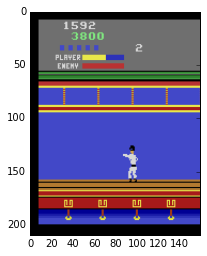

session # 0
 DOWNLEFTFIRE(qv = 0.488643079996) -> 0.0 |  DOWNLEFTFIRE(qv = 0.405981987715) -> 0.0 |  LEFTFIRE(qv = 0.00758884195238) -> 0.0 |  DOWNLEFTFIRE(qv = 0.453027546406) -> 0.0 |  LEFT(qv = 0.0819374620914) -> 0.0 |  DOWN(qv = 0.172681689262) -> 0.0 |  LEFT(qv = 0.0753720551729) -> 0.0 |  DOWN(qv = 0.172681689262) -> 0.0 |  DOWNRIGHT(qv = 0.0677148774266) -> 0.0 |  DOWNLEFTFIRE(qv = 0.453027546406) -> 0.0 |  DOWNLEFTFIRE(qv = 0.423091292381) -> 0.0 |  DOWNLEFTFIRE(qv = 0.453027546406) -> 0.0 |  RIGHT(qv = 0.0690782517195) -> 0.0 |  DOWN(qv = 0.172681689262) -> 0.0 |  RIGHT(qv = 0.0626412704587) -> 0.0 |  DOWNLEFTFIRE(qv = 0.423025041819) -> 0.0 |  DOWNLEFTFIRE(qv = 0.423025041819) -> 0.0 |  DOWNLEFTFIRE(qv = 0.453027546406) -> 0.0 |  DOWNLEFTFIRE(qv = 0.453027546406) -> 0.0 |  DOWNLEFT(qv = 0.0294796563685) -> 0.0 |  DOWNLEFT(qv = 0.027956135571) -> 0.0 |  DOWNLEFTFIRE(qv = 0.423025041819) -> 0.0 |  RIGHT(qv = 0.0626412704587) -> 0.0 |  DOWN(qv = 0.169989809394) -> 0.0 |  DOWNLE

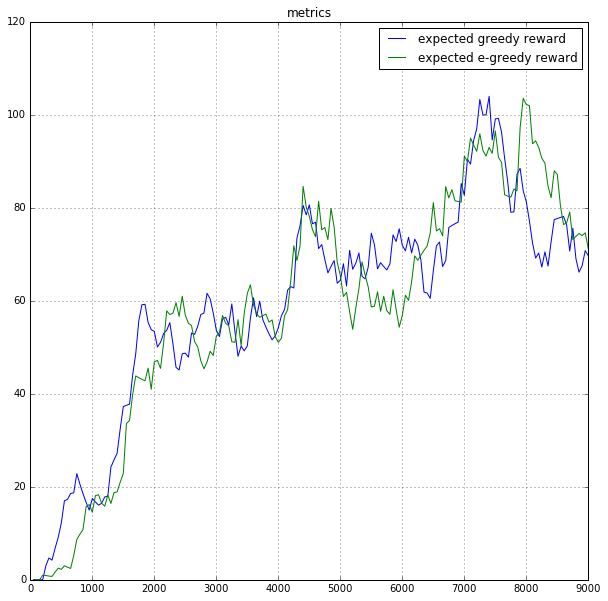

Random session examples


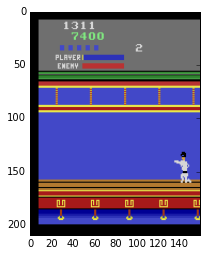

session # 0
 DOWNLEFTFIRE(qv = 0.59824603796) -> 0.0 |  DOWNLEFTFIRE(qv = 0.460698485374) -> 0.0 |  RIGHT(qv = 0.0975313782692) -> 0.0 |  RIGHT(qv = 0.0975313782692) -> 0.0 |  UPLEFTFIRE(qv = 0.0941454395652) -> 0.0 |  DOWNLEFTFIRE(qv = 0.460698485374) -> 0.0 |  RIGHT(qv = 0.0975313782692) -> 0.0 |  UPLEFTFIRE(qv = 0.0941454395652) -> 0.0 |  RIGHT(qv = 0.0975313782692) -> 0.0 |  DOWNLEFTFIRE(qv = 0.460698485374) -> 0.0 |  UPLEFTFIRE(qv = 0.0838492587209) -> 0.0 |  LEFT(qv = 0.0713172033429) -> 0.0 |  DOWNLEFTFIRE(qv = 0.455629736185) -> 0.0 |  DOWNRIGHT(qv = 0.146741047502) -> 0.0 |  DOWNLEFTFIRE(qv = 0.460698485374) -> 0.0 |  DOWNLEFTFIRE(qv = 0.460698485374) -> 0.0 |  DOWNLEFTFIRE(qv = 0.46045178175) -> 0.0 |  DOWNLEFT(qv = 0.0204326361418) -> 0.0 |  DOWN(qv = 0.126776009798) -> 0.0 |  DOWNLEFTFIRE(qv = 0.460698485374) -> 0.0 |  DOWNRIGHT(qv = 0.115227110684) -> 0.0 |  LEFT(qv = 0.0713172033429) -> 0.0 |  UPLEFTFIRE(qv = 0.0838492587209) -> 0.0 |  DOWNLEFTFIRE(qv = 0.455629736185) ->

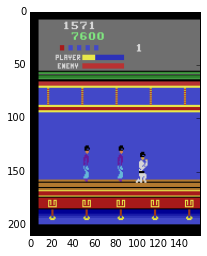

session # 0
 DOWNLEFTFIRE(qv = 0.589187085629) -> 0.0 |  DOWN(qv = 0.126756206155) -> 0.0 |  DOWNRIGHT(qv = 0.115257322788) -> 200.0 |  DOWNLEFTFIRE(qv = 0.460586518049) -> 0.0 |  DOWN(qv = 0.133072242141) -> 0.0 |  DOWN(qv = 0.133072242141) -> 0.0 |  UPLEFTFIRE(qv = 0.0941848903894) -> 0.0 |  DOWNLEFTFIRE(qv = 0.460586518049) -> 0.0 |  DOWNLEFTFIRE(qv = 0.460586518049) -> 0.0 |  DOWNLEFTFIRE(qv = 0.460586518049) -> 0.0 |  DOWN(qv = 0.133072242141) -> 0.0 |  UPLEFTFIRE(qv = 0.0941848903894) -> 0.0 |  DOWNRIGHT(qv = 0.115257322788) -> 200.0 |  LEFT(qv = 0.0663464069366) -> 0.0 |  UPLEFTFIRE(qv = 0.0941848903894) -> 0.0 |  DOWNLEFTFIRE(qv = 0.460586518049) -> 0.0 |  DOWNLEFTFIRE(qv = 0.455516219139) -> 0.0 |  RIGHT(qv = 0.0975557565689) -> 0.0 |  DOWNLEFTFIRE(qv = 0.460586518049) -> 0.0 |  DOWN(qv = 0.133072242141) -> 0.0 |  RIGHT(qv = 0.0975557565689) -> 0.0 |  DOWN(qv = 0.126756206155) -> 0.0 |  DOWNLEFTFIRE(qv = 0.455516219139) -> 0.0 |  DOWN(qv = 0.133072242141) -> 0.0 |  DOWNLEFTFIR

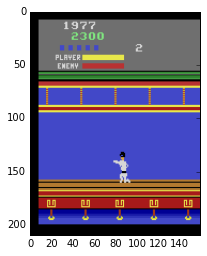

session # 0
 RIGHT(qv = 0.0490883290768) -> 0.0 |  RIGHT(qv = 0.0975314304233) -> 0.0 |  DOWN(qv = 0.1330922544) -> 0.0 |  DOWNLEFTFIRE(qv = 0.46069842577) -> 0.0 |  DOWN(qv = 0.1330922544) -> 0.0 |  DOWNLEFTFIRE(qv = 0.46069842577) -> 0.0 |  DOWNRIGHT(qv = 0.11522706598) -> 0.0 |  DOWN(qv = 0.1330922544) -> 0.0 |  RIGHT(qv = 0.0975314304233) -> 0.0 |  DOWNLEFT(qv = 0.0243537388742) -> 0.0 |  LEFT(qv = 0.0663093179464) -> 0.0 |  RIGHT(qv = 0.0975314304233) -> 0.0 |  DOWNLEFTFIRE(qv = 0.45562967658) -> 0.0 |  RIGHT(qv = 0.0975314304233) -> 0.0 |  DOWNLEFTFIRE(qv = 0.45562967658) -> 0.0 |  LEFT(qv = 0.0663093179464) -> 0.0 |  DOWNRIGHT(qv = 0.11522706598) -> 0.0 |  DOWNRIGHT(qv = 0.11522706598) -> 0.0 |  DOWN(qv = 0.126776069403) -> 0.0 |  DOWNLEFTFIRE(qv = 0.45562967658) -> 0.0 |  LEFT(qv = 0.0713172256947) -> 0.0 |  DOWNRIGHT(qv = 0.146740913391) -> 0.0 |  UPLEFTFIRE(qv = 0.0941454768181) -> 0.0 |  DOWN(qv = 0.1330922544) -> 0.0 |  DOWNLEFTFIRE(qv = 0.46069842577) -> 0.0 | reached max 

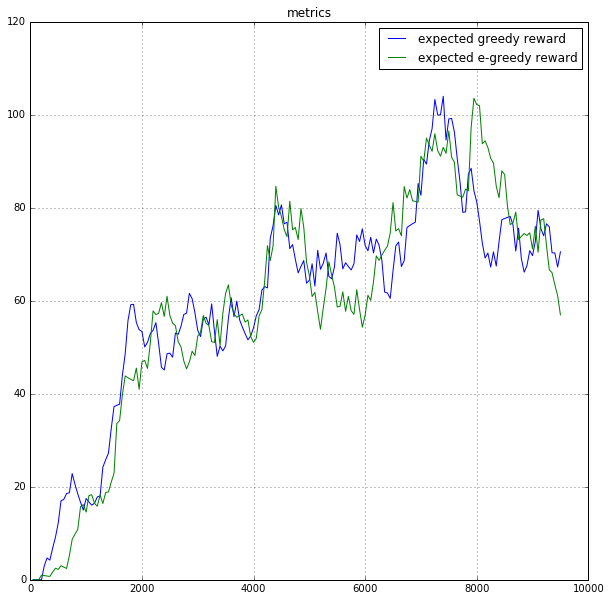

Random session examples


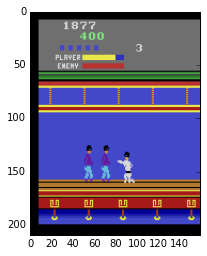

session # 0
 DOWNLEFTFIRE(qv = 0.573862075806) -> 0.0 |  DOWNRIGHT(qv = 0.120140753686) -> 0.0 |  DOWNRIGHT(qv = 0.120140753686) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648733854) -> 200.0 |  DOWN(qv = 0.149198964238) -> 0.0 |  LEFT(qv = 0.0689879208803) -> 0.0 |  LEFT(qv = 0.0689879208803) -> 0.0 |  LEFT(qv = 0.0689879208803) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648733854) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648733854) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648733854) -> 0.0 |  DOWNLEFT(qv = 0.0277891643345) -> 0.0 |  LEFT(qv = 0.0689879208803) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648733854) -> 0.0 |  DOWN(qv = 0.149198964238) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648733854) -> 0.0 |  UPLEFTFIRE(qv = 0.0979698449373) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648733854) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648733854) -> 0.0 |  DOWNRIGHT(qv = 0.120140753686) -> 0.0 |  DOWNRIGHT(qv = 0.152490705252) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648733854) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648733854) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648733854)

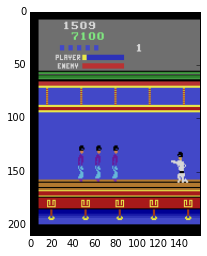

session # 0
 DOWNLEFTFIRE(qv = 0.413786888123) -> 0.0 |  DOWNRIGHT(qv = 0.120138391852) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648644447) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648644447) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648644447) -> 0.0 |  DOWN(qv = 0.149198204279) -> 0.0 |  RIGHT(qv = 0.0794057175517) -> 0.0 |  UPLEFTFIRE(qv = 0.0979722738266) -> 0.0 |  DOWN(qv = 0.149198204279) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648644447) -> 0.0 |  RIGHT(qv = 0.0794057175517) -> 0.0 |  RIGHT(qv = 0.0794057175517) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648644447) -> 0.0 |  UPLEFTFIRE(qv = 0.0979722738266) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648644447) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648644447) -> 0.0 |  LEFT(qv = 0.0689866319299) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648644447) -> 200.0 |  DOWNLEFTFIRE(qv = 0.447648644447) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648644447) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648644447) -> 0.0 |  DOWN(qv = 0.149198204279) -> 0.0 |  RIGHT(qv = 0.0794057175517) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447648644447)

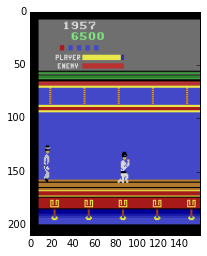

session # 0
 DOWNLEFTFIRE(qv = 0.550700247288) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447650462389) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447650283575) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447650283575) -> 0.0 |  DOWN(qv = 0.149198830128) -> 0.0 |  UPLEFTFIRE(qv = 0.0979720875621) -> 0.0 |  RIGHT(qv = 0.0794041603804) -> 0.0 |  RIGHT(qv = 0.0794041603804) -> 0.0 |  LEFT(qv = 0.0689867287874) -> 0.0 |  RIGHT(qv = 0.0794041603804) -> 0.0 |  DOWNLEFT(qv = 0.0277889817953) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447650283575) -> 0.0 |  DOWN(qv = 0.149198830128) -> 0.0 |  LEFT(qv = 0.0689867287874) -> 0.0 |  DOWNLEFT(qv = 0.0277889817953) -> 0.0 |  DOWN(qv = 0.149198830128) -> 0.0 |  DOWN(qv = 0.149198830128) -> 0.0 |  DOWNRIGHT(qv = 0.120137922466) -> 0.0 |  DOWNRIGHT(qv = 0.120137922466) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447650283575) -> 0.0 |  LEFT(qv = 0.0689867287874) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447650283575) -> 0.0 |  DOWN(qv = 0.149198830128) -> 0.0 |  DOWNLEFTFIRE(qv = 0.447650283575) -> 0.0 |  DOWN(qv = 0.14919883012

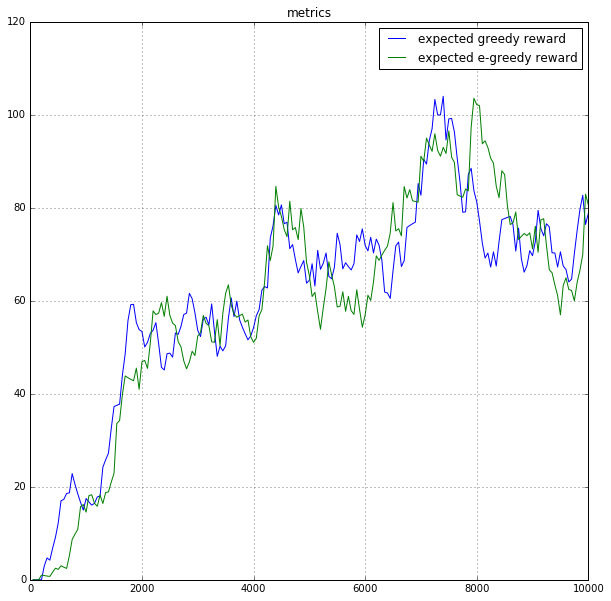

Random session examples


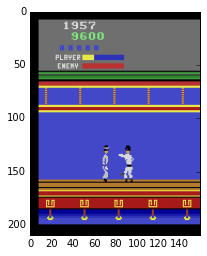

session # 0
 UPLEFTFIRE(qv = 0.090125001967) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458091825247) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458091825247) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458091825247) -> 0.0 |  UPLEFTFIRE(qv = 0.0905552655458) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458091825247) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458091825247) -> 0.0 |  DOWN(qv = 0.169031322002) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458091825247) -> 0.0 |  DOWN(qv = 0.169031322002) -> 0.0 |  LEFTFIRE(qv = 0.00375949172303) -> 0.0 |  DOWN(qv = 0.169031322002) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458091825247) -> 0.0 |  DOWN(qv = 0.169031322002) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458091825247) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458091825247) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458091825247) -> 0.0 |  DOWNLEFT(qv = 0.0437427721918) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458091825247) -> 0.0 |  DOWN(qv = 0.169031322002) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458091825247) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458091825247) -> 0.0 |  DOWNLEFT(qv = 0.0437427721918) -> 0.0 |  LEFT(qv = 0.0657157599926)

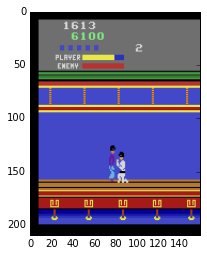

session # 0
 DOWN(qv = 0.0990485027432) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458083987236) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458083987236) -> 0.0 |  RIGHT(qv = 0.0866602510214) -> 0.0 |  DOWNLEFT(qv = 0.0369439907372) -> 0.0 |  DOWNLEFT(qv = 0.0437407530844) -> 0.0 |  LEFT(qv = 0.0657159462571) -> 0.0 |  DOWN(qv = 0.169037982821) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458083987236) -> 0.0 |  DOWNRIGHT(qv = 0.0811439603567) -> 0.0 |  RIGHT(qv = 0.0866602510214) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458083987236) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458083987236) -> 0.0 |  LEFT(qv = 0.0657159462571) -> 0.0 |  RIGHT(qv = 0.0866602510214) -> 0.0 |  DOWN(qv = 0.169037982821) -> 0.0 |  LEFT(qv = 0.0657159462571) -> 0.0 |  RIGHT(qv = 0.0866602510214) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458083987236) -> 0.0 |  RIGHT(qv = 0.0866602510214) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458083987236) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458083987236) -> 0.0 |  DOWN(qv = 0.169037982821) -> 0.0 |  DOWNLEFT(qv = 0.0437407530844) -> 0.0 |  RIGHT(qv = 0.08666025102

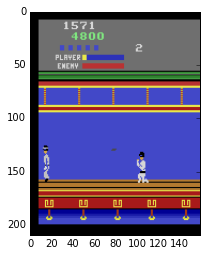

session # 0
 UPLEFTFIRE(qv = 0.105600140989) -> 0.0 |  RIGHT(qv = 0.086660079658) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458084493876) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458084493876) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458084493876) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458084493876) -> 0.0 |  DOWNRIGHT(qv = 0.0811436250806) -> 0.0 |  UPLEFTFIRE(qv = 0.0850389003754) -> 0.0 |  RIGHT(qv = 0.086660079658) -> 0.0 |  UPLEFTFIRE(qv = 0.090556114912) -> 0.0 |  DOWN(qv = 0.169038027525) -> 0.0 |  DOWN(qv = 0.169038027525) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458084493876) -> 0.0 |  LEFT(qv = 0.0657157972455) -> 0.0 |  DOWNLEFT(qv = 0.0437406562269) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458084493876) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458084493876) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458084493876) -> 0.0 |  DOWNLEFT(qv = 0.0437406562269) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458084493876) -> 0.0 |  DOWNLEFTFIRE(qv = 0.458084493876) -> 0.0 |  DOWN(qv = 0.169038027525) -> 0.0 |  DOWNRIGHT(qv = 0.0811436250806) -> 0.0 |  LEFT(qv = 0.0657157972455) -> 0.0 |

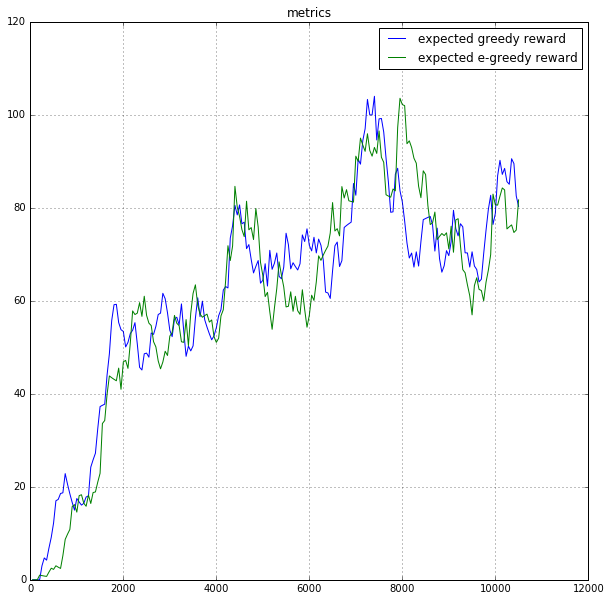

Random session examples


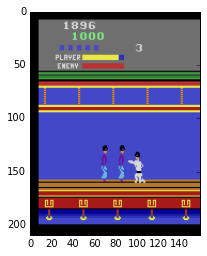

session # 0
 LEFTFIRE(qv = 0.0026777992025) -> 0.0 |  DOWNLEFTFIRE(qv = 0.487525761127) -> 200.0 |  RIGHT(qv = 0.107640698552) -> 0.0 |  DOWN(qv = 0.166979804635) -> 0.0 |  LEFT(qv = 0.0530978366733) -> 0.0 |  DOWNLEFTFIRE(qv = 0.449755817652) -> 0.0 |  UPLEFTFIRE(qv = 0.085256151855) -> 200.0 |  DOWNLEFTFIRE(qv = 0.408921122551) -> 0.0 |  DOWNLEFTFIRE(qv = 0.408921122551) -> 0.0 |  DOWNLEFTFIRE(qv = 0.449755817652) -> 0.0 |  DOWNLEFTFIRE(qv = 0.449755817652) -> 0.0 |  LEFT(qv = 0.0567444562912) -> 0.0 |  DOWNRIGHT(qv = 0.142377898097) -> 0.0 |  DOWNLEFTFIRE(qv = 0.449755817652) -> 0.0 |  DOWN(qv = 0.14373897016) -> 0.0 |  DOWNLEFTFIRE(qv = 0.449755817652) -> 0.0 |  DOWNLEFTFIRE(qv = 0.34963837266) -> 0.0 |  DOWNRIGHT(qv = 0.155384197831) -> 0.0 |  UPLEFTFIRE(qv = 0.0809884667397) -> 0.0 |  UPLEFTFIRE(qv = 0.0809884667397) -> 0.0 |  DOWNLEFTFIRE(qv = 0.449755817652) -> 0.0 |  DOWNLEFTFIRE(qv = 0.408921122551) -> 0.0 |  UPLEFTFIRE(qv = 0.085256151855) -> 0.0 |  DOWN(qv = 0.14373897016) 

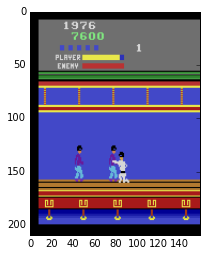

session # 0
 LEFT(qv = 0.072743371129) -> 0.0 |  DOWNLEFTFIRE(qv = 0.449755907059) -> 0.0 |  RIGHT(qv = 0.107640765607) -> 0.0 |  DOWNLEFTFIRE(qv = 0.40892124176) -> 0.0 |  UPLEFTFIRE(qv = 0.0852561444044) -> 0.0 |  DOWNRIGHT(qv = 0.155384123325) -> 0.0 |  DOWNLEFTFIRE(qv = 0.40892124176) -> 0.0 |  DOWNLEFTFIRE(qv = 0.40892124176) -> 0.0 |  DOWN(qv = 0.14373883605) -> 0.0 |  RIGHT(qv = 0.103992126882) -> 0.0 |  RIGHT(qv = 0.103992126882) -> 0.0 |  DOWNLEFTFIRE(qv = 0.449755907059) -> 200.0 |  DOWNLEFTFIRE(qv = 0.449755907059) -> 0.0 |  DOWN(qv = 0.14373883605) -> 0.0 |  UPLEFTFIRE(qv = 0.0809884592891) -> 0.0 |  DOWNRIGHT(qv = 0.142377838492) -> 0.0 |  DOWNLEFTFIRE(qv = 0.449755907059) -> 0.0 |  DOWNLEFTFIRE(qv = 0.40892124176) -> 0.0 |  DOWNLEFTFIRE(qv = 0.449755907059) -> 0.0 |  RIGHT(qv = 0.107640765607) -> 0.0 |  LEFT(qv = 0.0567444674671) -> 0.0 |  DOWNLEFTFIRE(qv = 0.449755907059) -> 0.0 |  UPLEFTFIRE(qv = 0.0809884592891) -> 0.0 |  DOWNRIGHT(qv = 0.155384123325) -> 0.0 |  DOWNLE

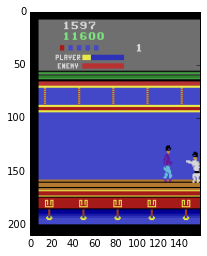

session # 0
 DOWNLEFTFIRE(qv = 0.478427112103) -> 0.0 |  UPLEFTFIRE(qv = 0.0809936448932) -> 0.0 |  DOWNRIGHT(qv = 0.120842650533) -> 0.0 |  DOWNLEFTFIRE(qv = 0.449740290642) -> 0.0 |  DOWNLEFT(qv = 0.0177019927651) -> 0.0 |  RIGHT(qv = 0.103994764388) -> 0.0 |  DOWN(qv = 0.166976287961) -> 0.0 |  DOWNLEFTFIRE(qv = 0.408906459808) -> 0.0 |  DOWNLEFTFIRE(qv = 0.408906459808) -> 0.0 |  DOWNLEFTFIRE(qv = 0.408906459808) -> 0.0 |  DOWNLEFTFIRE(qv = 0.449740290642) -> 0.0 |  DOWNLEFTFIRE(qv = 0.449740290642) -> 0.0 |  DOWNRIGHT(qv = 0.142383411527) -> 0.0 |  RIGHT(qv = 0.103994764388) -> 0.0 |  LEFT(qv = 0.056749433279) -> 0.0 |  LEFT(qv = 0.056749433279) -> 0.0 |  DOWNLEFTFIRE(qv = 0.449740290642) -> 0.0 |  DOWN(qv = 0.166976287961) -> 0.0 |  DOWN(qv = 0.14373613894) -> 0.0 |  DOWNRIGHT(qv = 0.142383411527) -> 0.0 |  DOWNLEFTFIRE(qv = 0.449740290642) -> 0.0 |  DOWNLEFTFIRE(qv = 0.449740290642) -> 0.0 |  DOWNLEFTFIRE(qv = 0.408906459808) -> 0.0 |  DOWNRIGHT(qv = 0.155389979482) -> 0.0 |  DO

In [ ]:
n_epochs = 25000
batch_size= 10

for i in range(n_epochs):    
    
    
    #train
    update_pool(env,pool,replay_seq_len)
    resolver.rng.seed(i)    
    loss,avg_reward = train_fun()
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%1 ==0:
        current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/2500.)
        epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##record current learning progress and show learning curves
    if epoch_counter%50 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        epsilon.set_value(0)
        update_pool(env,pool,replay_seq_len)

        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        epsilon.set_value(np.float32(current_epsilon))
        update_pool(env,pool,replay_seq_len)

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

    if epoch_counter %500 ==0:
        print "Learning curves:"
        score_log.plot()


        print "Random session examples"
        display_sessions(with_plots=False)
    
    #save snapshot
    if epoch_counter %1000 ==0:
        snap_name = "{}.epoch{}.pcl".format(os.path.join(snapshot_path,experiment_setup_name), epoch_counter)
        save(resolver,snap_name)
        print "saved", snap_name

        
        
    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results
 * Here we plot learning curves and sample testimonials

In [ ]:
score_log.plot("final")

In [ ]:
print "Random session examples"
display_sessions(with_plots=True)


# Submission

In [ ]:
epsilon.set_value(0)

In [ ]:

save_path = '/tmp/AgentNet-simplenet-SpaceInvadersv0-Recording0'

subm_env = gym.make(GAME_TITLE)

#starting monitor. This setup does not write videos
subm_env.monitor.start(save_path,lambda i: False,force=True)

#this setup does
#subm_env.monitor.start(save_path,force=True)


for i_episode in xrange(200):
    
    #initial observation
    observation = subm_env.reset()
    #initial memory
    prev_memories = [np.zeros((1,)+tuple(mem.output_shape[1:]),dtype=floatX) 
                         for mem in agent.state_variables]
    
    
    t = 0
    while True:

        action,new_memories = step([observation],prev_memories)
        observation, reward, done, info = subm_env.step(action)
        
        prev_memories = new_memories
        if done:
            print "Episode finished after {} timesteps".format(t+1)
            break
        t+=1

subm_env.monitor.close()

In [ ]:
gym.monitoring._monitors.clear()

In [ ]:

gym.upload(save_path,
           
           #this notebook
           writeup=<url to my gist>, 
           
           #your api key
           api_key=<my_own_api_key>)
